In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

In [2]:
# First of all we download  our dataset from the seaborn python library dataset
# Then, we add a 'date' column joining together 'year' and 'month'. We need it for plots.

df = sns.load_dataset("flights")

# Create a 'date' y-m-d column 
months = pd.to_datetime(df.month, format='%b').dt.month
df['date'] = pd.to_datetime(dict(year=df.year, month=months, day=1))
df = df[['date', 'year', 'month', 'passengers']]

# Order months chronologically as opposed to alphabetically
months_categories = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df["month"] = pd.Categorical(df["month"], categories = months_categories)

# Check results
df.head()

date  year month  passengers
0 1949-01-01  1949   Jan         112
1 1949-02-01  1949   Feb         118
2 1949-03-01  1949   Mar         132
3 1949-04-01  1949   Apr         129
4 1949-05-01  1949   May         121

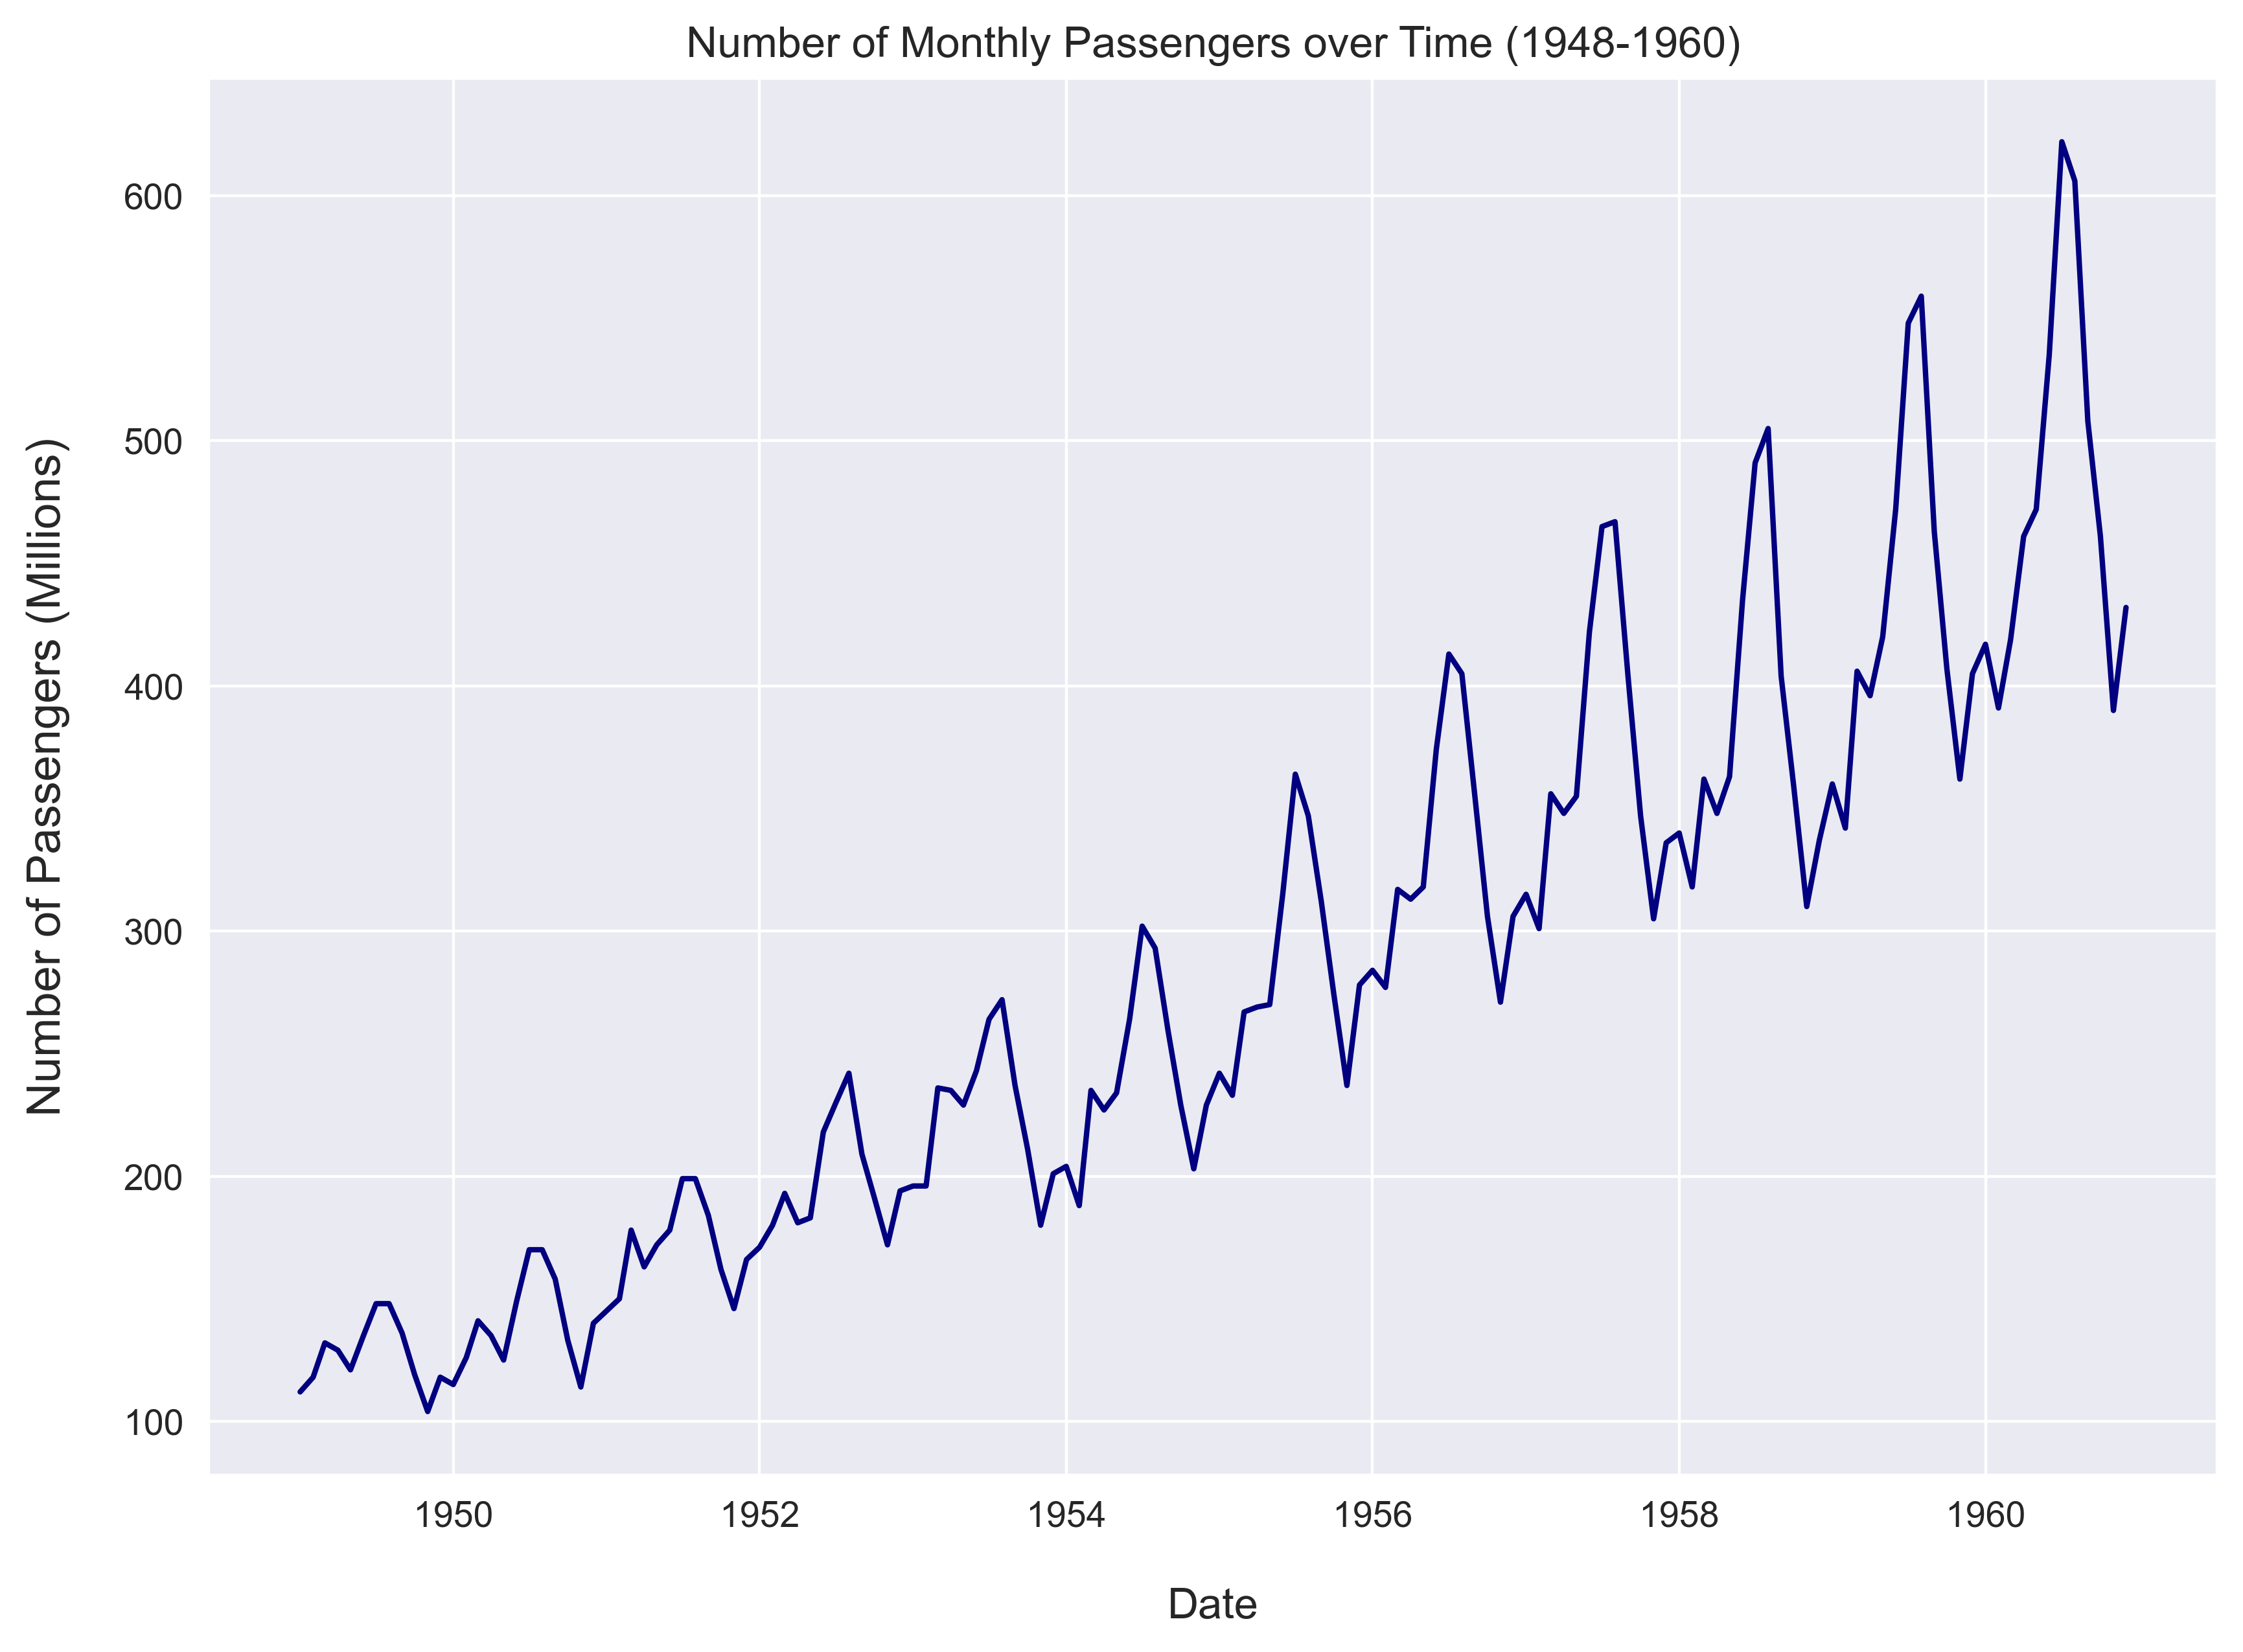

In [3]:
# Plot whole series

sns.set_style('darkgrid')
plt.figure(figsize=(10,7), dpi=400)
sns.lineplot(data=df, x='date', y='passengers', color='navy')
plt.ylabel('Number of Passengers (Millions)', size=13, labelpad=15)
plt.xlabel('Date', size=12, labelpad=15)
plt.title('Number of Monthly Passengers over Time (1948-1960)', size=12)
plt.show()

#
### Seasonal Decomposition

In [4]:
decompose_result = seasonal_decompose(df.set_index('date')['passengers'], 
                                      model="multiplicative", period=12)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

#
#### Seasonal Decomposition Plot

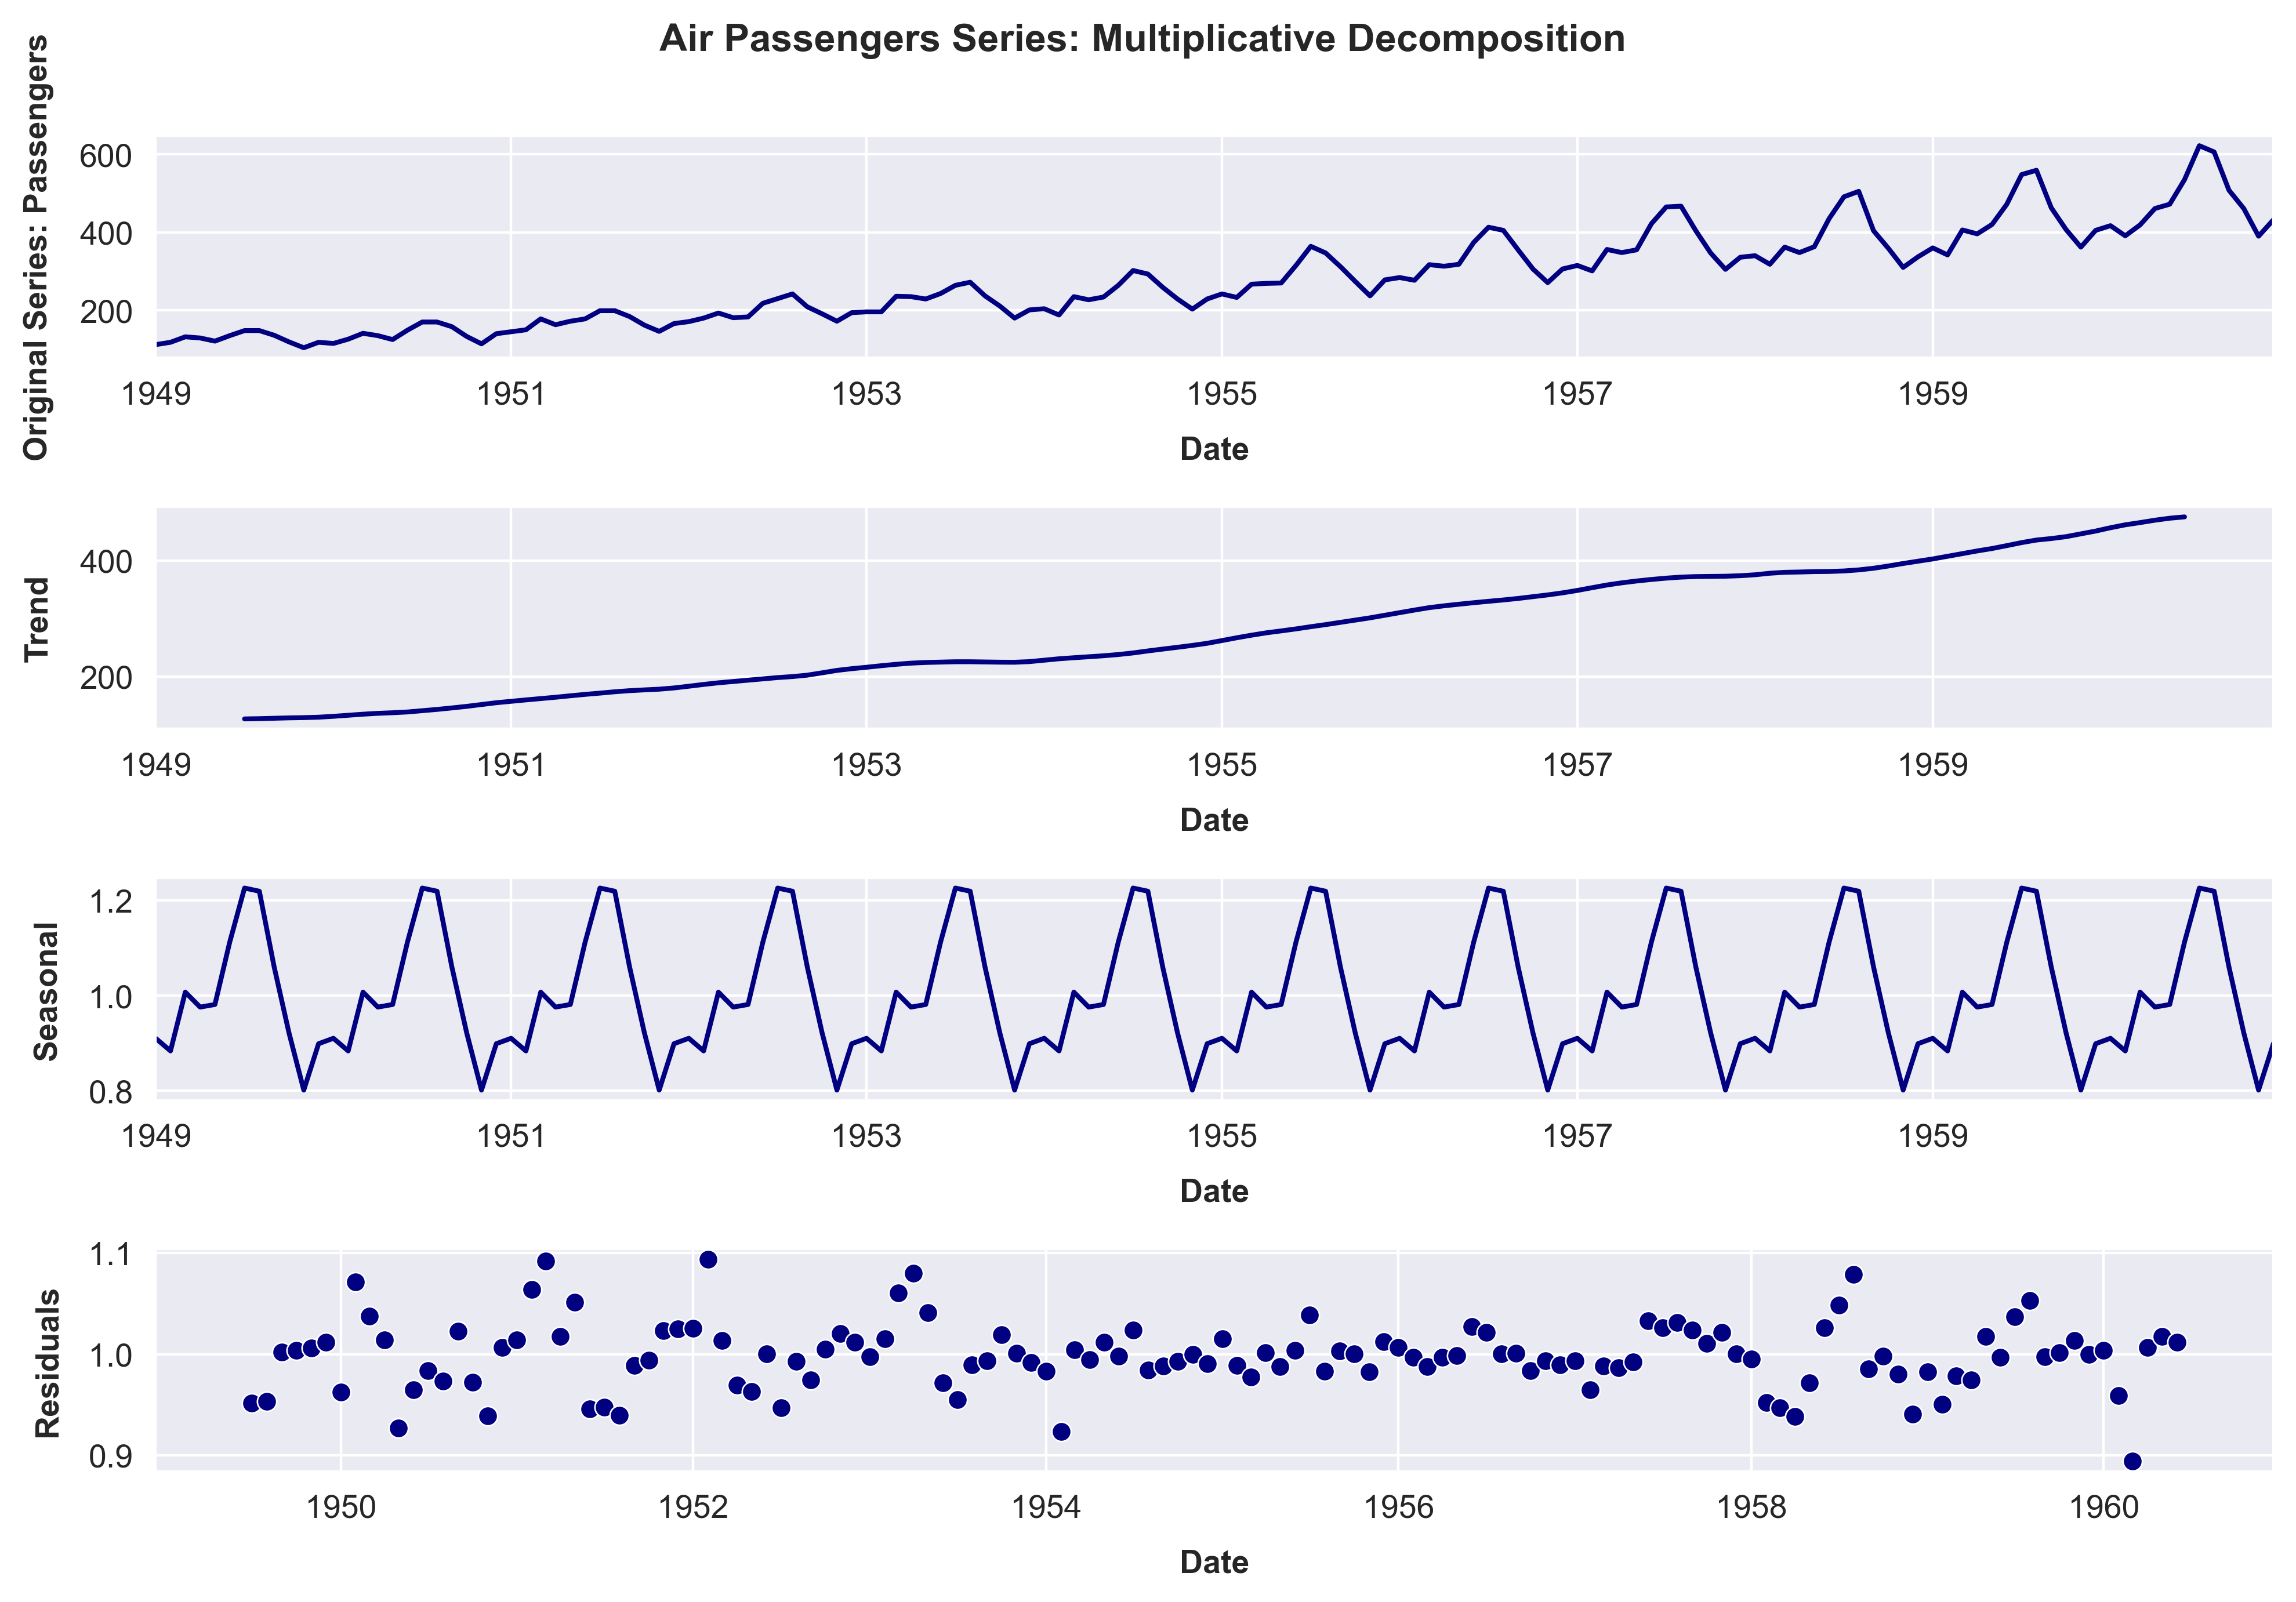

In [5]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,7), dpi=400)
plt.suptitle('Air Passengers Series: Multiplicative Decomposition \n', size=12, weight='bold')

plt.subplot(4,1,1)
df.set_index('date')['passengers'].plot(color='navy')
plt.ylabel('Original Series: Passengers', weight='bold', labelpad=8)
plt.xlabel('Date', weight='bold', labelpad=8)

plt.subplot(4,1,2)
trend.plot(color='navy')
plt.ylabel('Trend', weight='bold', labelpad=8)
plt.xlabel('Date', weight='bold', labelpad=8)

plt.subplot(4,1,3)
seasonal.plot(color='navy')
plt.ylabel('Seasonal', weight='bold', labelpad=8)
plt.xlabel('Date', weight='bold', labelpad=8)

plt.subplot(4,1,4)
sns.scatterplot(residual, color='navy')
plt.ylabel('Residuals', weight='bold', labelpad=8)
plt.xlabel('Date', weight='bold', labelpad=8)

plt.tight_layout()
plt.show()

#
#### Check the residuals for stationarity

In [6]:
# Put the Residuals through the Augmented Dickey-Fuller  and KPSS tests

print(('Augmented Dickey-Fuller Test').upper(), '\n'
      'Null Hypothesis: There is NO Stationarity', '\n')
# Serie original sin transformar
result = adfuller(residual.dropna())
print('ADF Statistic: %f' % result[0])
if result[1] >= 0.05:
    print('p-value: %f' % result[1], '\n'
          'H0 is not rejected', '\n'
          '*** The series is NOT stationary ***')
else:
    print('p-value: %f' % result[1], '\n'
          'H0 is rejectected', '\n'
          '*** The series IS stationary ***')
print('=======================================\n')

######### KPSS Test ######################
print(('Kwiatkowski-Phillips-Schmidt-Shin Test').upper(), '\n',
      'Null Hypothesis: There IS stationarity', '\n')
# Serie original sin transformar
result = kpss(residual.dropna())
print('KPSS Statistic: %f' % result[0])
if result[1] < 0.05:
    print('p-value: %f' % result[1], '\n'
          'H0 is rejected', '\n'
          '*** The series is NOT stationary ***')
else:
    print('p-value: %f' % result[1], '\n'
          'H0 is not rejected', '\n'
          '*** The series IS stationary ***')
print('=======================================')

AUGMENTED DICKEY-FULLER TEST 
Null Hypothesis: There is NO Stationarity 

ADF Statistic: -7.415925
p-value: 0.000000 
H0 is rejectected 
*** The series IS stationary ***

KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST 
 Null Hypothesis: There IS stationarity 

KPSS Statistic: 0.036063
p-value: 0.100000 
H0 is not rejected 
*** The series IS stationary ***


#### This means the series has been correctly decomposed
# 
### Let's create three rolling cross validation folds

In [7]:
train1, test1, _ = np.split(df, [int(1/4*len(df)), int(2/4*len(df))])
train2, test2, _ = np.split(df, [int(2/4*len(df)), int(3/4*len(df))])
train3, test3, _ = np.split(df, [int(3/4*len(df)), int(4/4*len(df))])

#
#### Now, we're gonna decompose train1, train2 and train3 series into trend, seasonal and residual components

In [8]:
# train1 decomposition
decompose_result_1 = seasonal_decompose(train1['passengers'], 
                                      model="multiplicative", period=12)

trend1 = pd.DataFrame(decompose_result_1.trend)
seasonal1 = pd.DataFrame(decompose_result_1.seasonal)
residual1 = decompose_result_1.resid

# train2 decomposition
decompose_result_2 = seasonal_decompose(train2['passengers'], 
                                      model="multiplicative", period=12)

trend2 = pd.DataFrame(decompose_result_2.trend)
seasonal2 = pd.DataFrame(decompose_result_2.seasonal)
residual2 = decompose_result_2.resid

# train3 decomposition
decompose_result_3 = seasonal_decompose(train3['passengers'], 
                                      model="multiplicative", period=12)

trend3 = pd.DataFrame(decompose_result_3.trend)
seasonal3 = pd.DataFrame(decompose_result_3.seasonal)
residual3 = decompose_result_3.resid

# 
#### We need to create a seasonal component for test data. It's simply the same seasonal component of the corresponding train data

In [9]:
test1.reset_index(inplace=True)
test1['seasonal'] = seasonal1.iloc[:len(test1)]['seasonal']
test1.set_index('index', inplace=True)

test2.reset_index(inplace=True)
test2['seasonal'] = seasonal2.iloc[:len(test2)]['seasonal']
test2.set_index('index', inplace=True)

test3.reset_index(inplace=True)
test3['seasonal'] = seasonal3.iloc[:len(test3)]['seasonal']
test3.set_index('index', inplace=True)

#
#### Also we need to create trend data for test dataframes. We'll make them with poly fits based on the seasonal decomposition trend components

#
### We create the final predictions and prediction intervals by multiplying the predicted trends and P.I. by the seasonal the corresponding component.

In [10]:
# Fit a first degree model for each trend
for trend, test in zip([trend1, trend2, trend3], [test1, test2, test3]):
    # Define variables
    y = trend['trend'].dropna()
    X = trend['trend'].dropna().index

    # Fit ols model 
    model = sm.OLS(y, sm.add_constant(X)).fit()
    # and make predictions
    ols_pred = model.get_prediction(sm.add_constant(test.index))

    # Create final variables by multiplying by the seasonal component 
    # and INSERT THEM IN THE TEST DATAFRAME
    test.reset_index(inplace=True)
    test['predict'] = ols_pred.summary_frame()['mean']*test.seasonal
    test['obs_ci_lower'] = ols_pred.summary_frame()['obs_ci_lower']*test.seasonal
    test['obs_ci_upper'] = ols_pred.summary_frame()['obs_ci_upper']*test.seasonal
    
    # set the original index
    test.set_index('index', inplace=True)

In [11]:
# Fit a second degree model for each trend
for trend, test in zip([trend1, trend2, trend3], [test1, test2, test3]):
    
    y = trend['trend'].dropna()
    X = np.column_stack((trend['trend'].dropna().index,
                        trend['trend'].dropna().index**2))
    
    # Fit model
    model = sm.OLS(y, sm.add_constant(X)).fit()
    # Make Predictions
    Xnew = np.column_stack((test.index, 
                            test.index**2))
    ols_pred = model.get_prediction(sm.add_constant(Xnew))

    # Create final variables by multiplying by the seasonal component 
    # and insert them in test dataframe
    test.reset_index(inplace=True)
    test['predict_2d'] = ols_pred.summary_frame()['mean']*test.seasonal
    test['obs_ci_lower_2d'] = ols_pred.summary_frame()['obs_ci_lower']*test.seasonal
    test['obs_ci_upper_2d'] = ols_pred.summary_frame()['obs_ci_upper']*test.seasonal
     
    # set the original index
    test.set_index('index', inplace=True)

#
### We have to create the predictions (=polyfit trend*seasonal component)


#
#### Plot predictions along test data

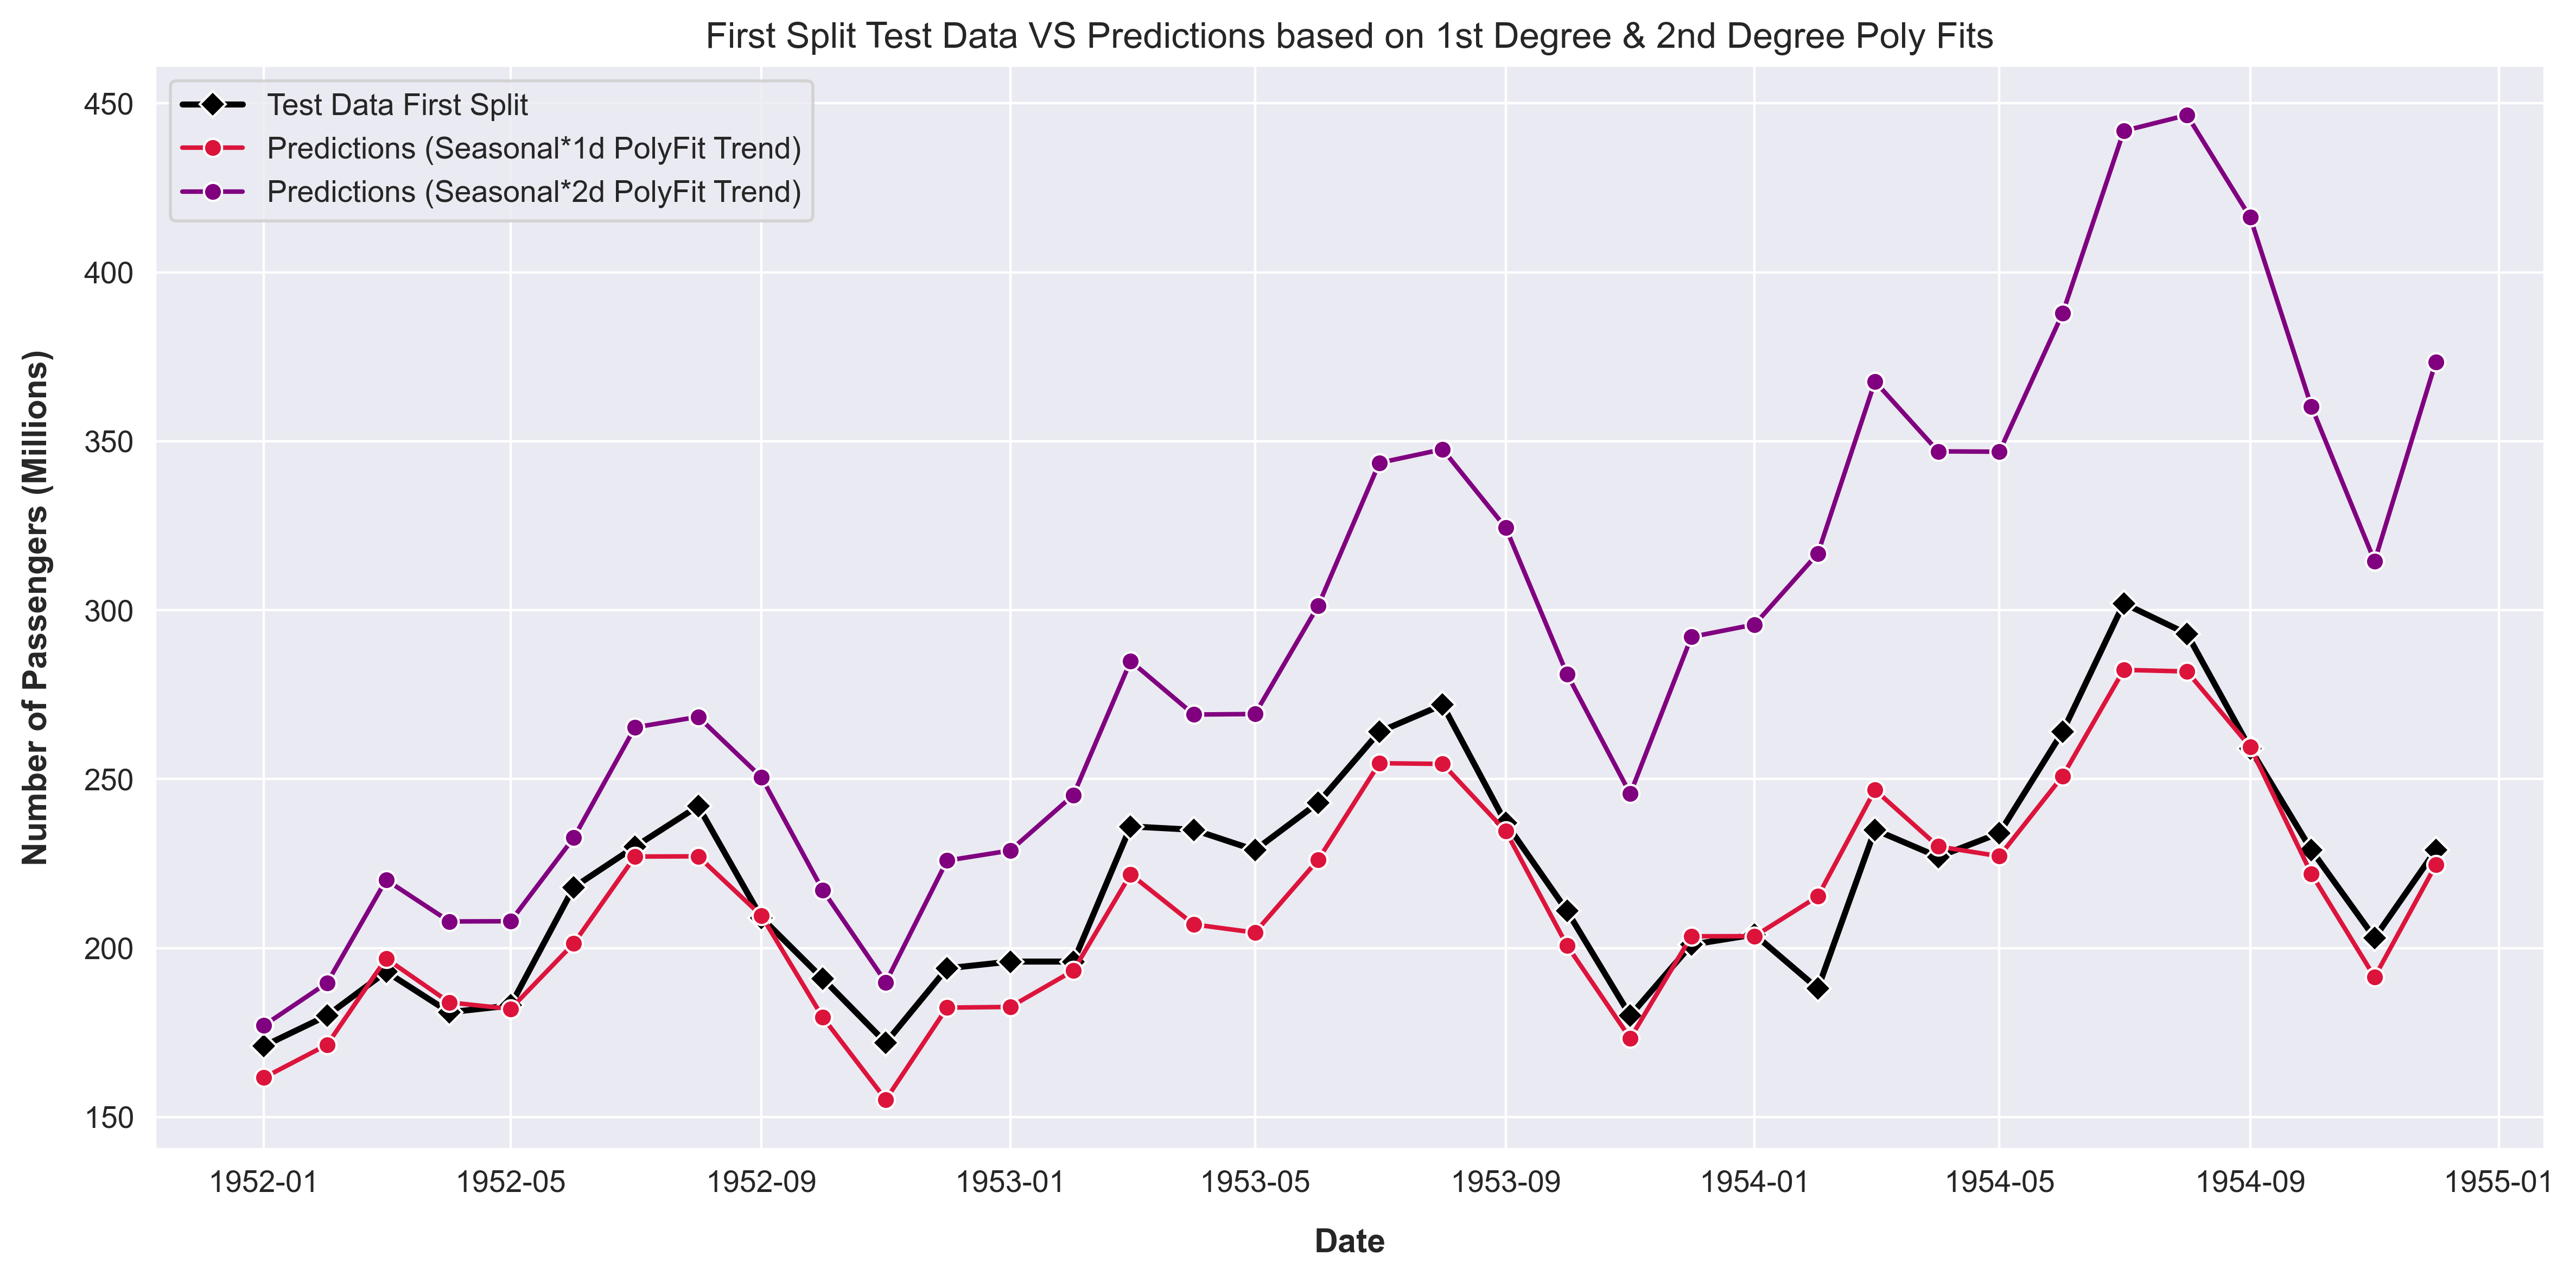

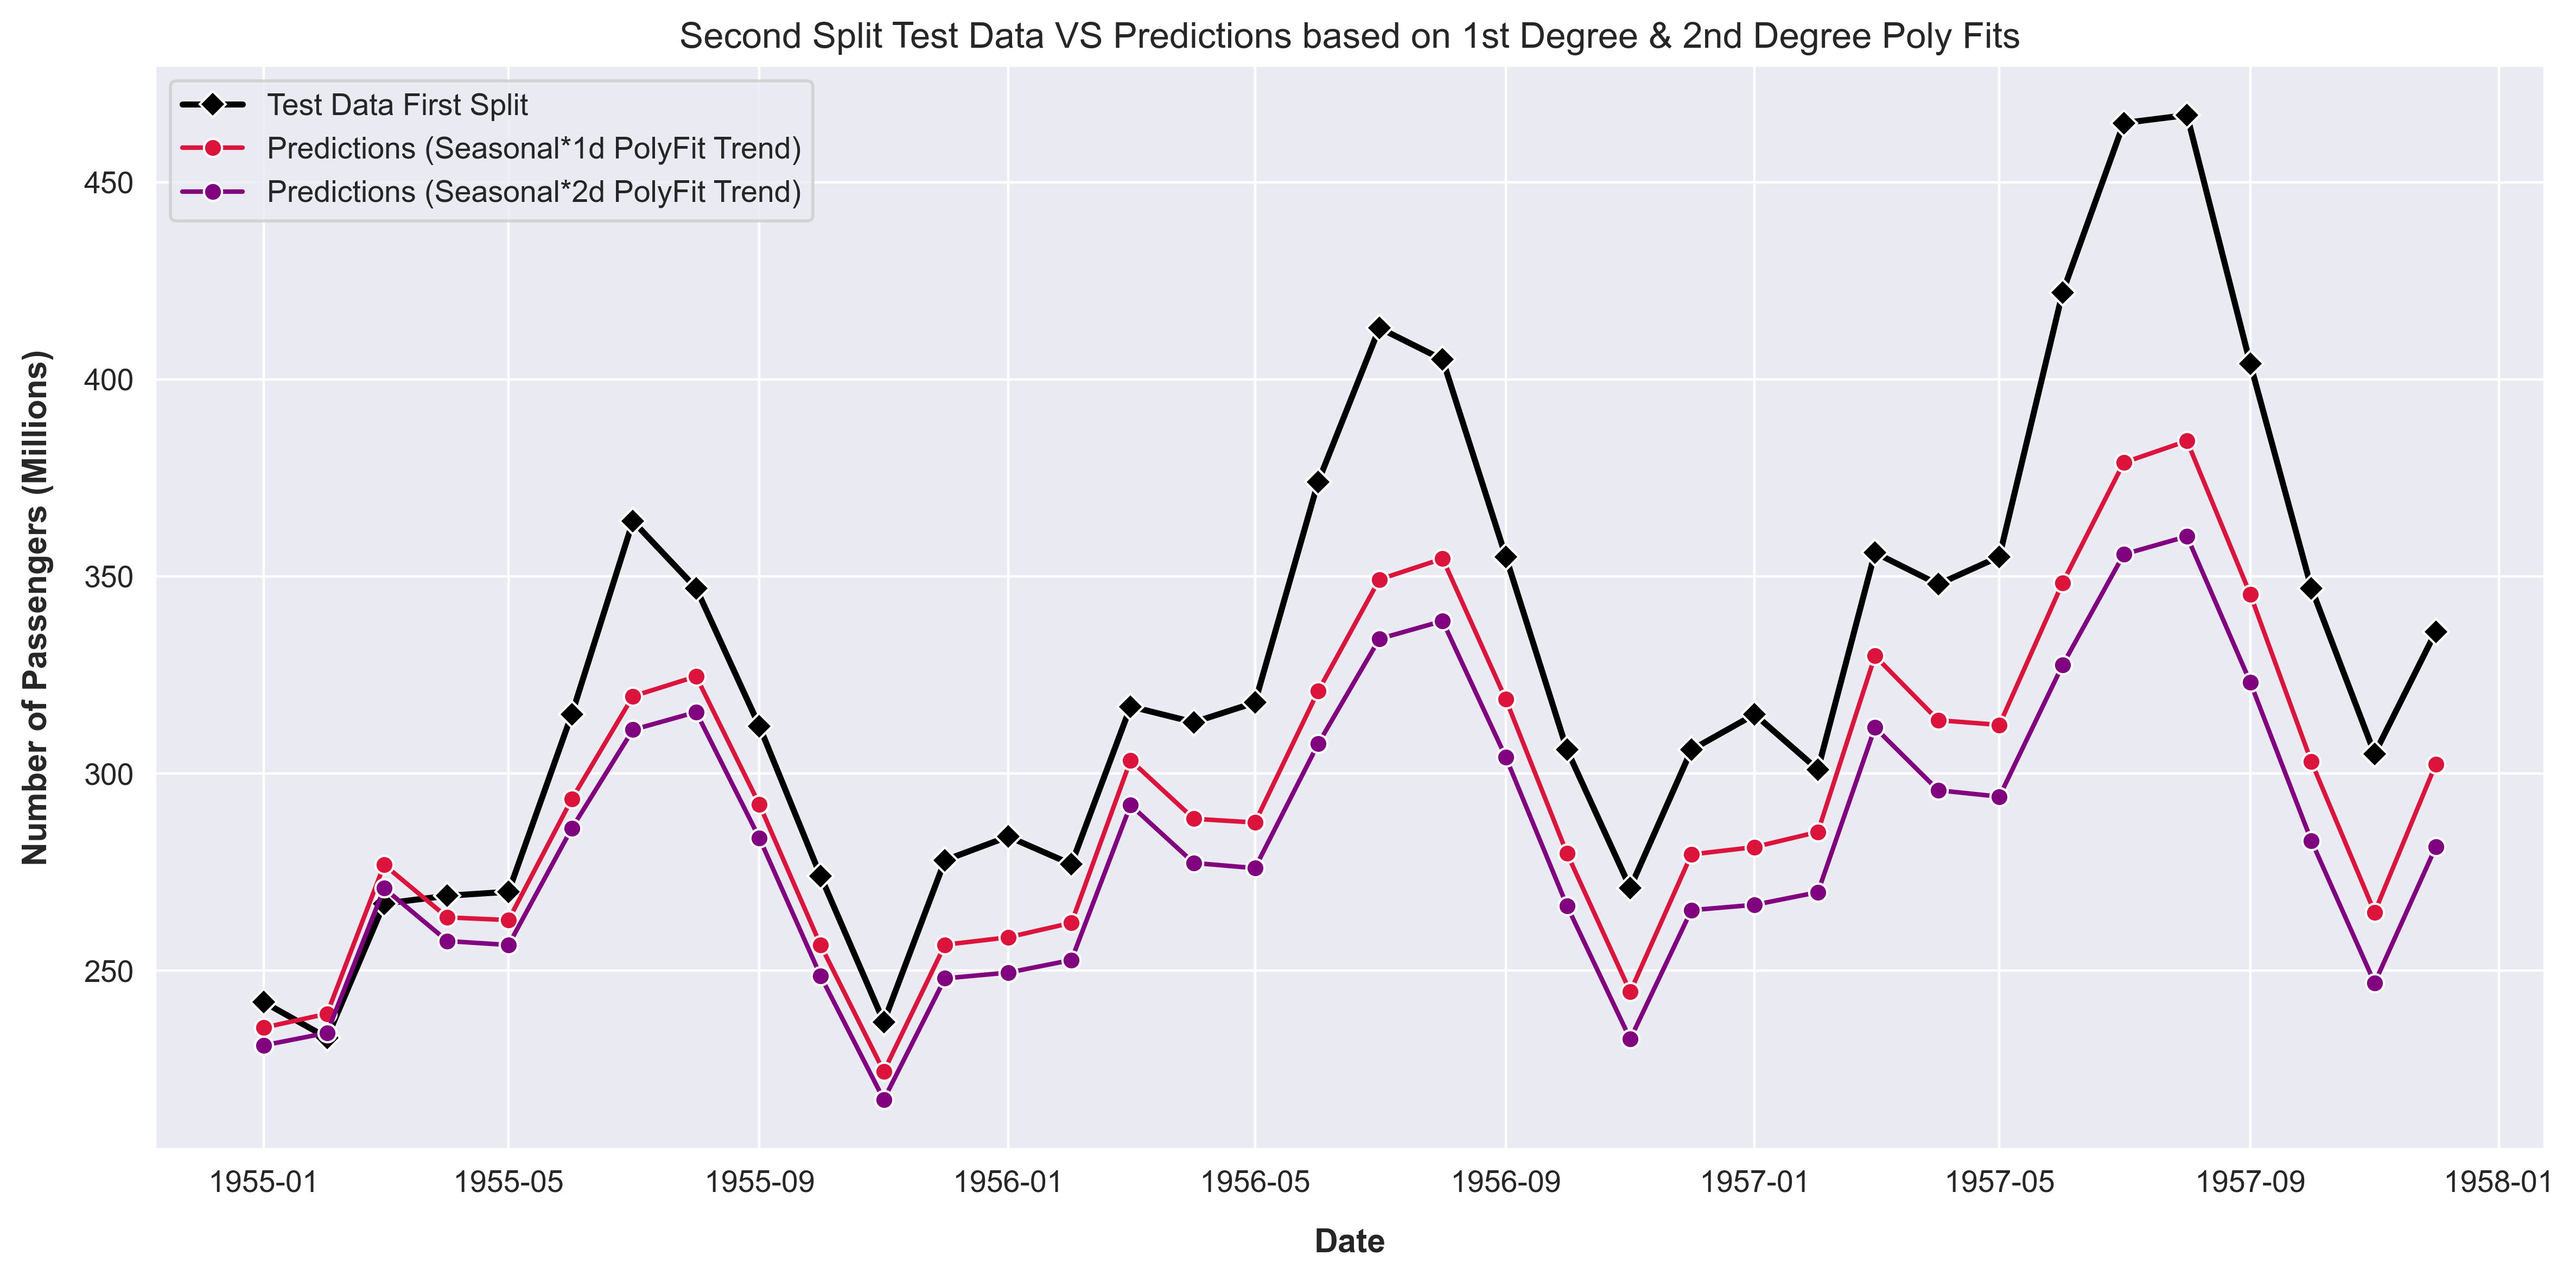

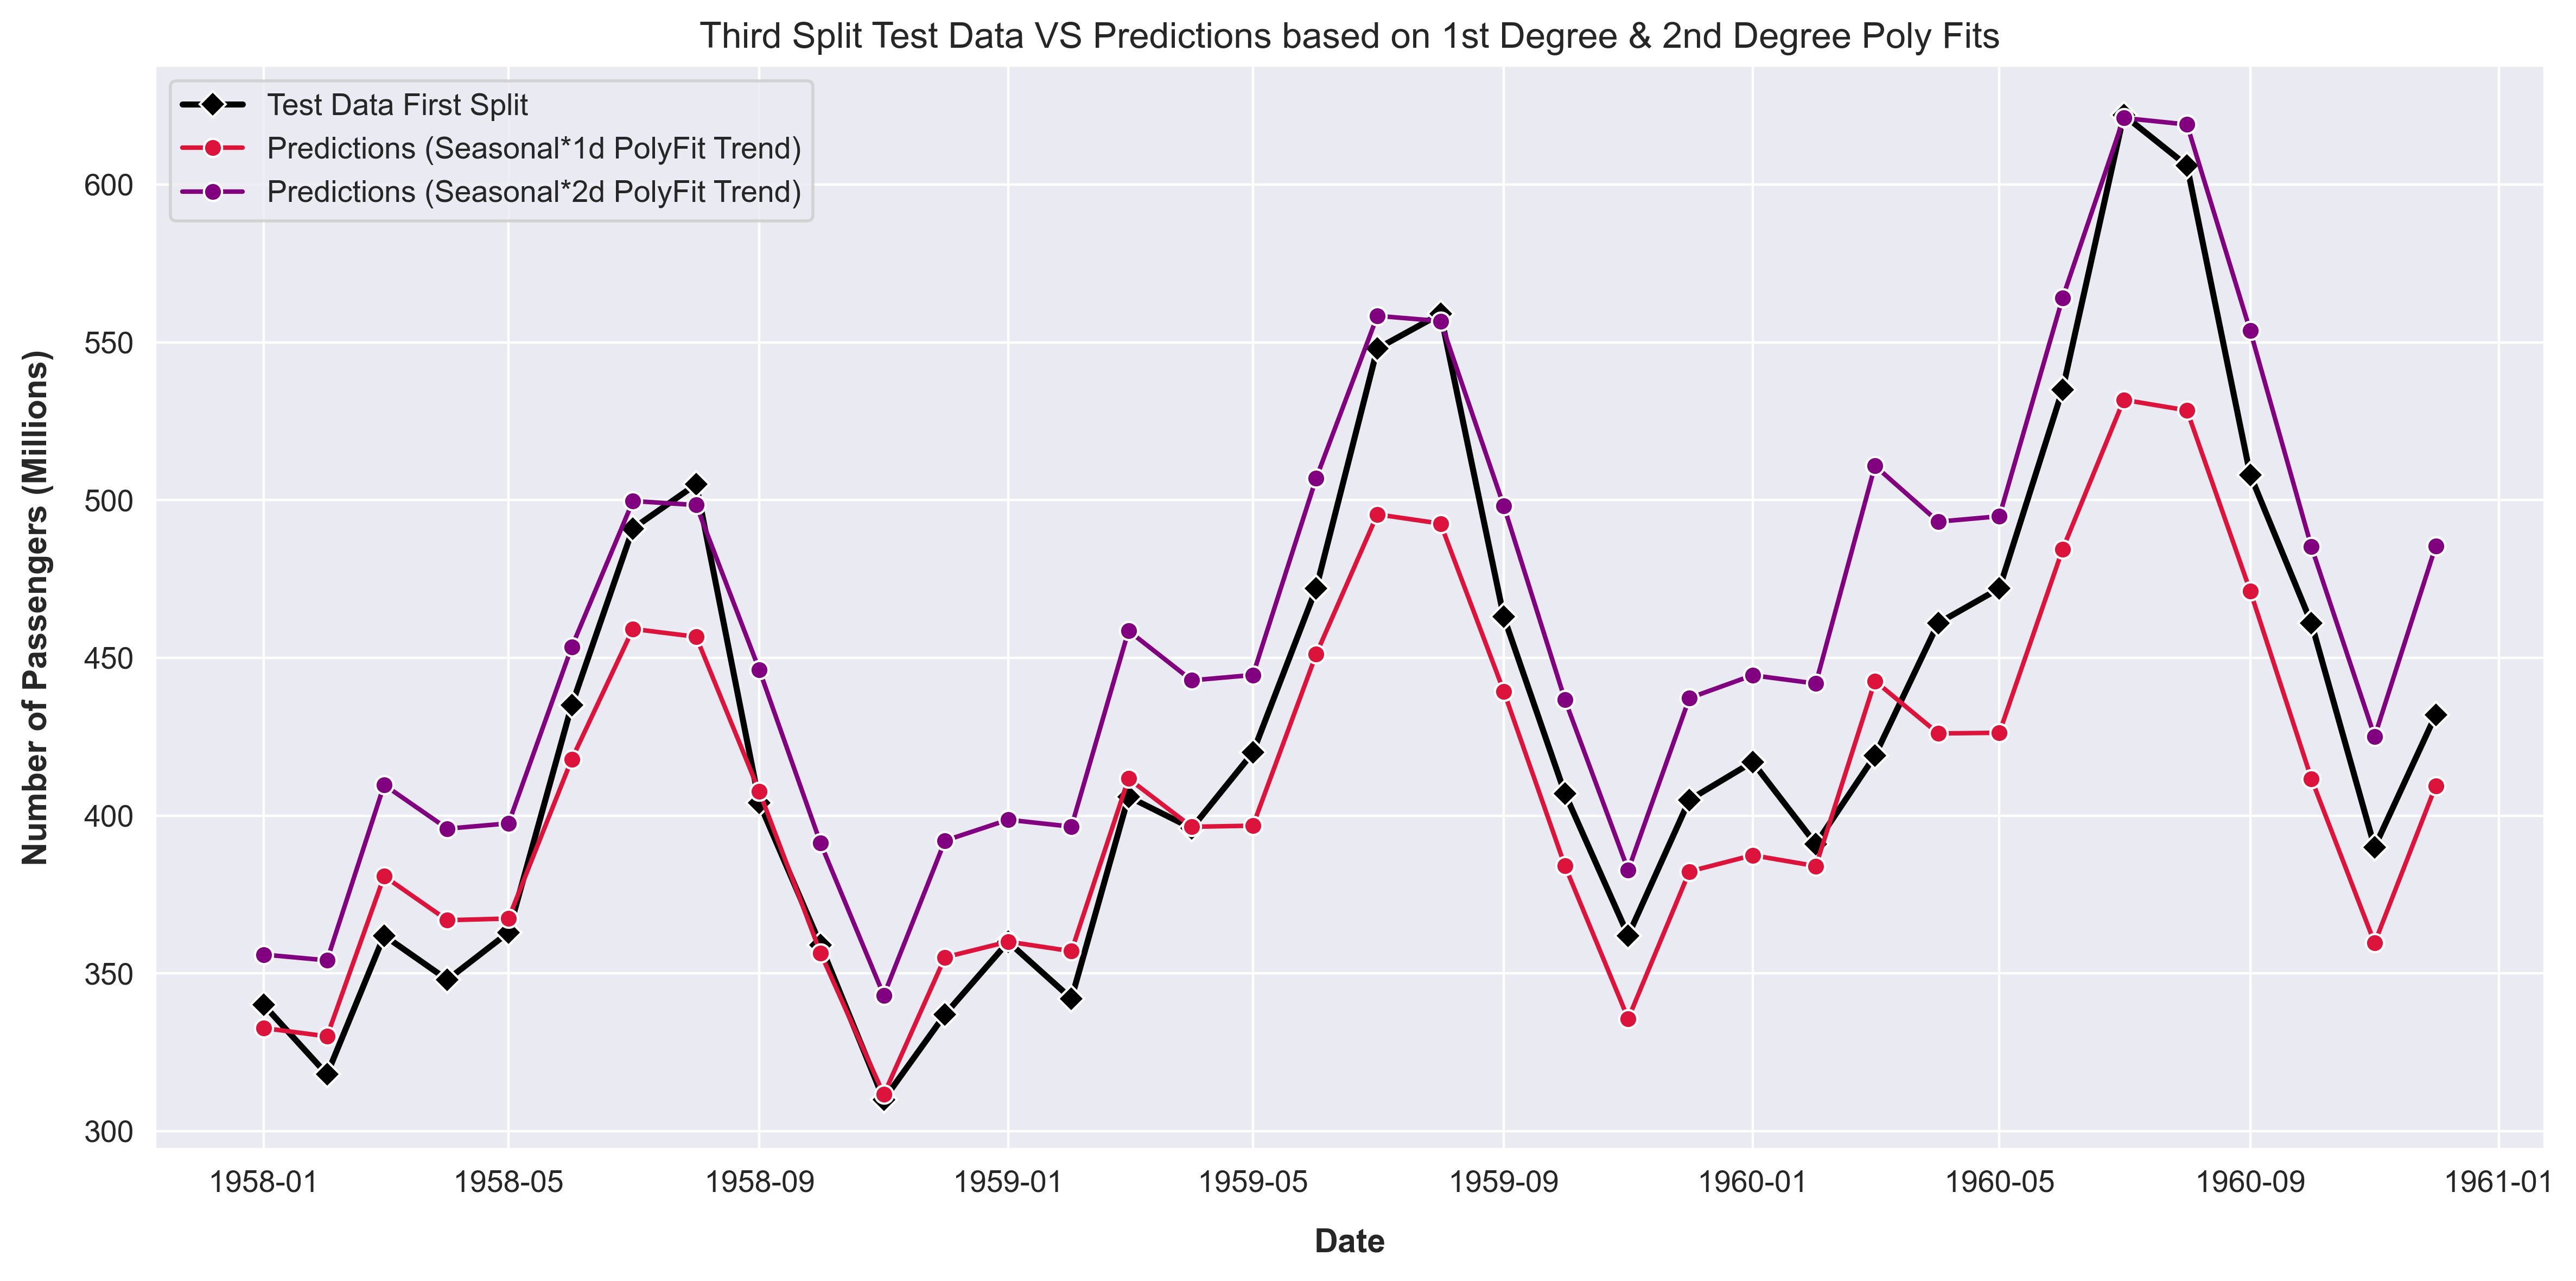

In [12]:
## Plots of test splits with predictions 
for split, test in zip(['First', 'Second', 'Third'], [test1, test2, test3]):
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,6), dpi=400)

    sns.lineplot(x=test.date, y=test.passengers, color='black', label='Test Data First Split',
                linewidth=2, marker='D')
    sns.lineplot(x=test.date, y=test['predict'], color='crimson', marker='o', 
                 label='Predictions (Seasonal*1d PolyFit Trend)')
    sns.lineplot(x=test.date, y=test['predict_2d'], color='purple', marker='o', 
                 label='Predictions (Seasonal*2d PolyFit Trend)')
    plt.ylabel('Number of Passengers (Millions)', weight='bold', size=11,labelpad=10)
    plt.xlabel('Date', weight='bold', size=11, labelpad=10)
    plt.title(split + ' Split Test Data VS Predictions based on 1st Degree & 2nd Degree Poly Fits')

    plt.tight_layout()
    plt.show()

#
#### Calculate error metrics scores

In [13]:
# import metrics from sklearn.metrics
def error_score(error_met, Y_test, pred):
    
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from math import sqrt
    
    # Define metrics
    mse = mean_squared_error(Y_test, pred)
    rmse =sqrt(mse)
    n_rmse = mean_squared_error(Y_test/Y_test, pred/Y_test)
    
    mae = mean_absolute_error(Y_test, pred)
    n_mae = mean_absolute_error(Y_test/Y_test, pred/Y_test)
    
    # Results
    if error_met=='rmse':
        return round(rmse,2)
    elif error_met=='n_rmse':
        return round(n_rmse*10, 2)
    elif error_met=='mae': 
        return round(mae, 2)
    elif error_met=='n_mae':
        return round(n_mae*10, 2)

In [14]:
score = []
tests = [test1, test2, test3]
error_met = ['rmse', 'n_rmse', 'mae', 'n_mae']
error_names = ['Root Mean Squared Error: ', 'Normalized RMSE (%): ',
               'Mean Absolute Error: ', 'Normalized MAE (%): ']
models = ['predict', 'predict_2d']
names = ['Seasonal*First Deg. PolyFit', 'Seasonal*Second Deg. PolyFit']

for model, name in zip(models, names):
    print('Model: '+name)
    for met, err_name in zip(error_met, error_names):
        print(err_name, end='')
        for test in tests:
            score.append(error_score(met, test.passengers, test[model]))
        print(score)
        score = []
    print()

Model: Seasonal*First Deg. PolyFit
Root Mean Squared Error: [12.56, 38.29, 34.3]
Normalized RMSE (%): [0.03, 0.1, 0.05]
Mean Absolute Error: [10.16, 32.17, 26.75]
Normalized MAE (%): [0.46, 0.92, 0.57]

Model: Seasonal*Second Deg. PolyFit
Root Mean Squared Error: [85.13, 51.8, 37.56]
Normalized RMSE (%): [1.34, 0.2, 0.09]
Mean Absolute Error: [71.38, 44.6, 32.99]
Normalized MAE (%): [3.13, 1.28, 0.83]



In [15]:
for model, name in zip(models, names):
    print('Model: '+name)
    for met, err_name in zip(error_met, error_names):
        print(err_name, end='')
        for test in tests:
            score.append(error_score(met, test.passengers, test[model]))
        print(round(np.mean(score),2))
        score = []
    print()

Model: Seasonal*First Deg. PolyFit
Root Mean Squared Error: 28.38
Normalized RMSE (%): 0.06
Mean Absolute Error: 23.03
Normalized MAE (%): 0.65

Model: Seasonal*Second Deg. PolyFit
Root Mean Squared Error: 58.16
Normalized RMSE (%): 0.54
Mean Absolute Error: 49.66
Normalized MAE (%): 1.75



# 
### Sum up results with tables

In [16]:
dicc = {'Root Mean Squared Error':[[12.56, 38.29, 34.3], [85.13, 51.8, 37.56]],
       'Normalized RMSE (%)': [[0.03, 0.1, 0.05], [1.34, 0.2, 0.09]],
       'Mean Absolute Error': [[10.16, 32.17, 26.75], [71.38, 44.6, 32.99]],
       'Normalized MAE (%)': [[0.46, 0.92, 0.57], [3.13, 1.28, 0.83]]}
tbl = pd.DataFrame(dicc).T
tbl.columns = ['Mod 1d', 'Mod 2d']
tbl.index.name = 'Metric'
tbl

Mod 1d                Mod 2d
Metric                                                              
Root Mean Squared Error   [12.56, 38.29, 34.3]  [85.13, 51.8, 37.56]
Normalized RMSE (%)          [0.03, 0.1, 0.05]     [1.34, 0.2, 0.09]
Mean Absolute Error      [10.16, 32.17, 26.75]  [71.38, 44.6, 32.99]
Normalized MAE (%)          [0.46, 0.92, 0.57]    [3.13, 1.28, 0.83]

In [17]:
dicc = {'Root Mean Squared Error':[28.38, 58.16],
       'Normalized RMSE (%)': [0.06, 0.54],
       'Mean Absolute Error': [23.03, 49.66],
       'Normalized MAE (%)': [0.65, 1.75]}
tbl1 = pd.DataFrame(dicc).T
tbl1.columns = ['Mod 1d', 'Mod 2d']
tbl1.index.name = 'Metric'
tbl1

Mod 1d  Mod 2d
Metric                                 
Root Mean Squared Error   28.38   58.16
Normalized RMSE (%)        0.06    0.54
Mean Absolute Error       23.03   49.66
Normalized MAE (%)         0.65    1.75

### *** Mod 1d is definitely better ***
#
### We're gonna try two more models. They are like the previous ones but with a twist. Rather than fitting the polynomials to the trend, we'll fit them to the train data.

#
### Plot original data and prediction intervals for Model 1

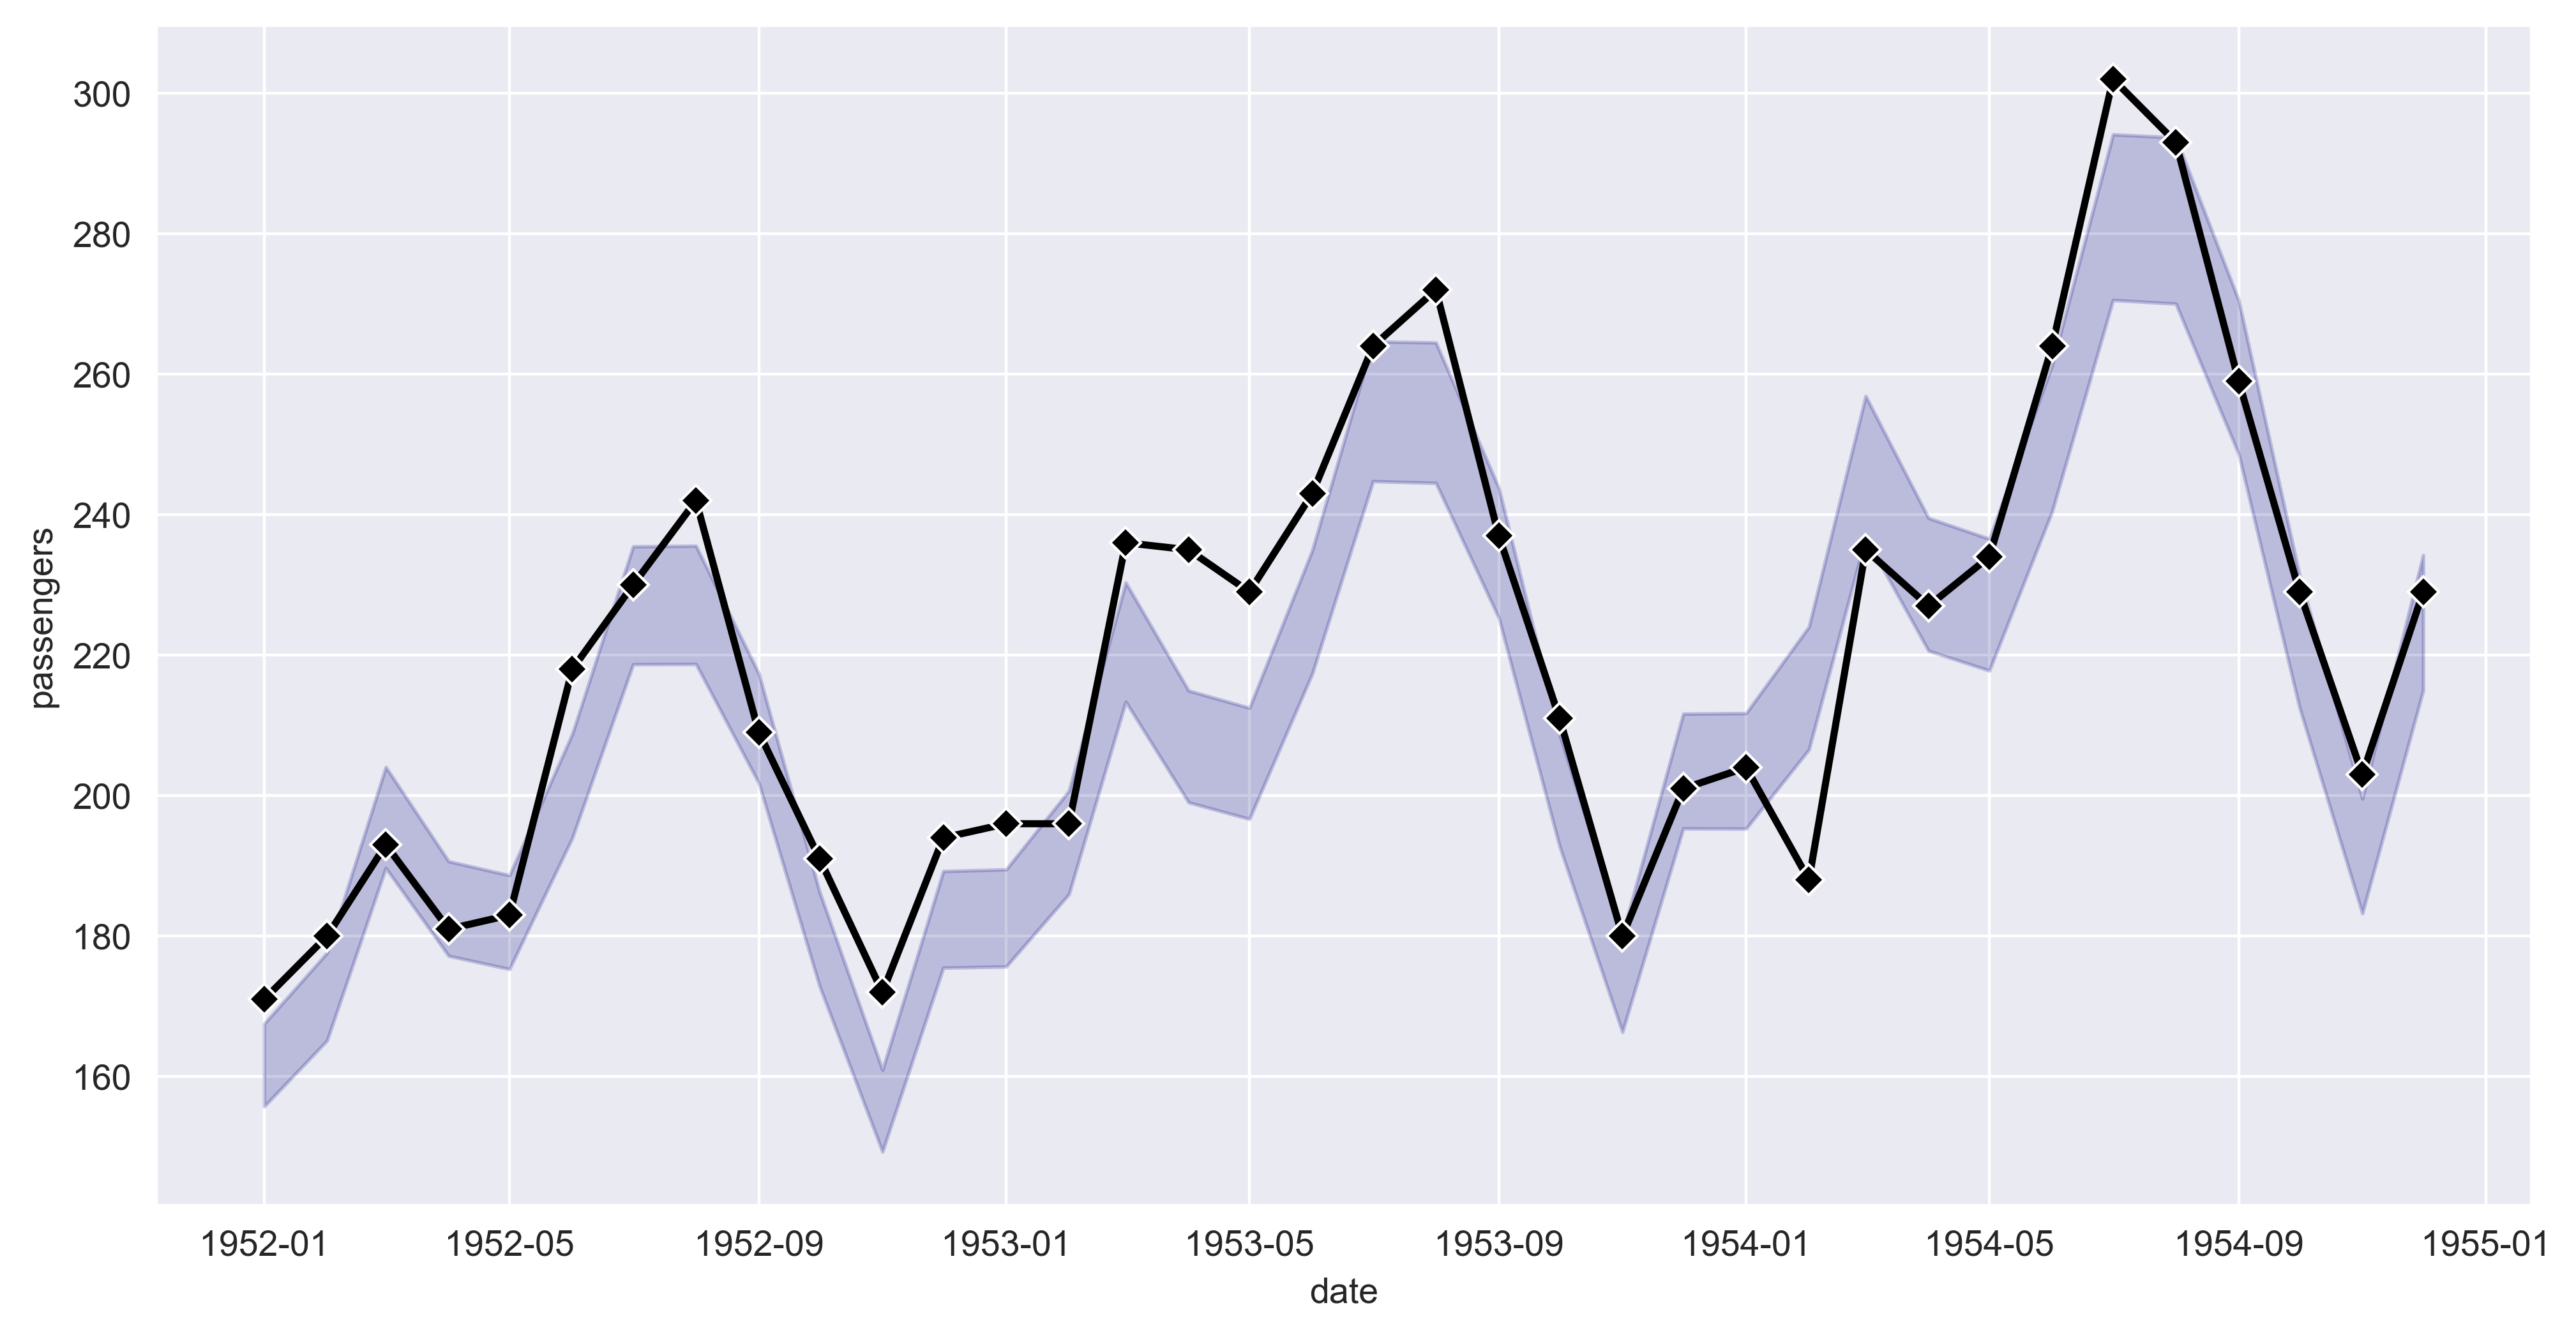

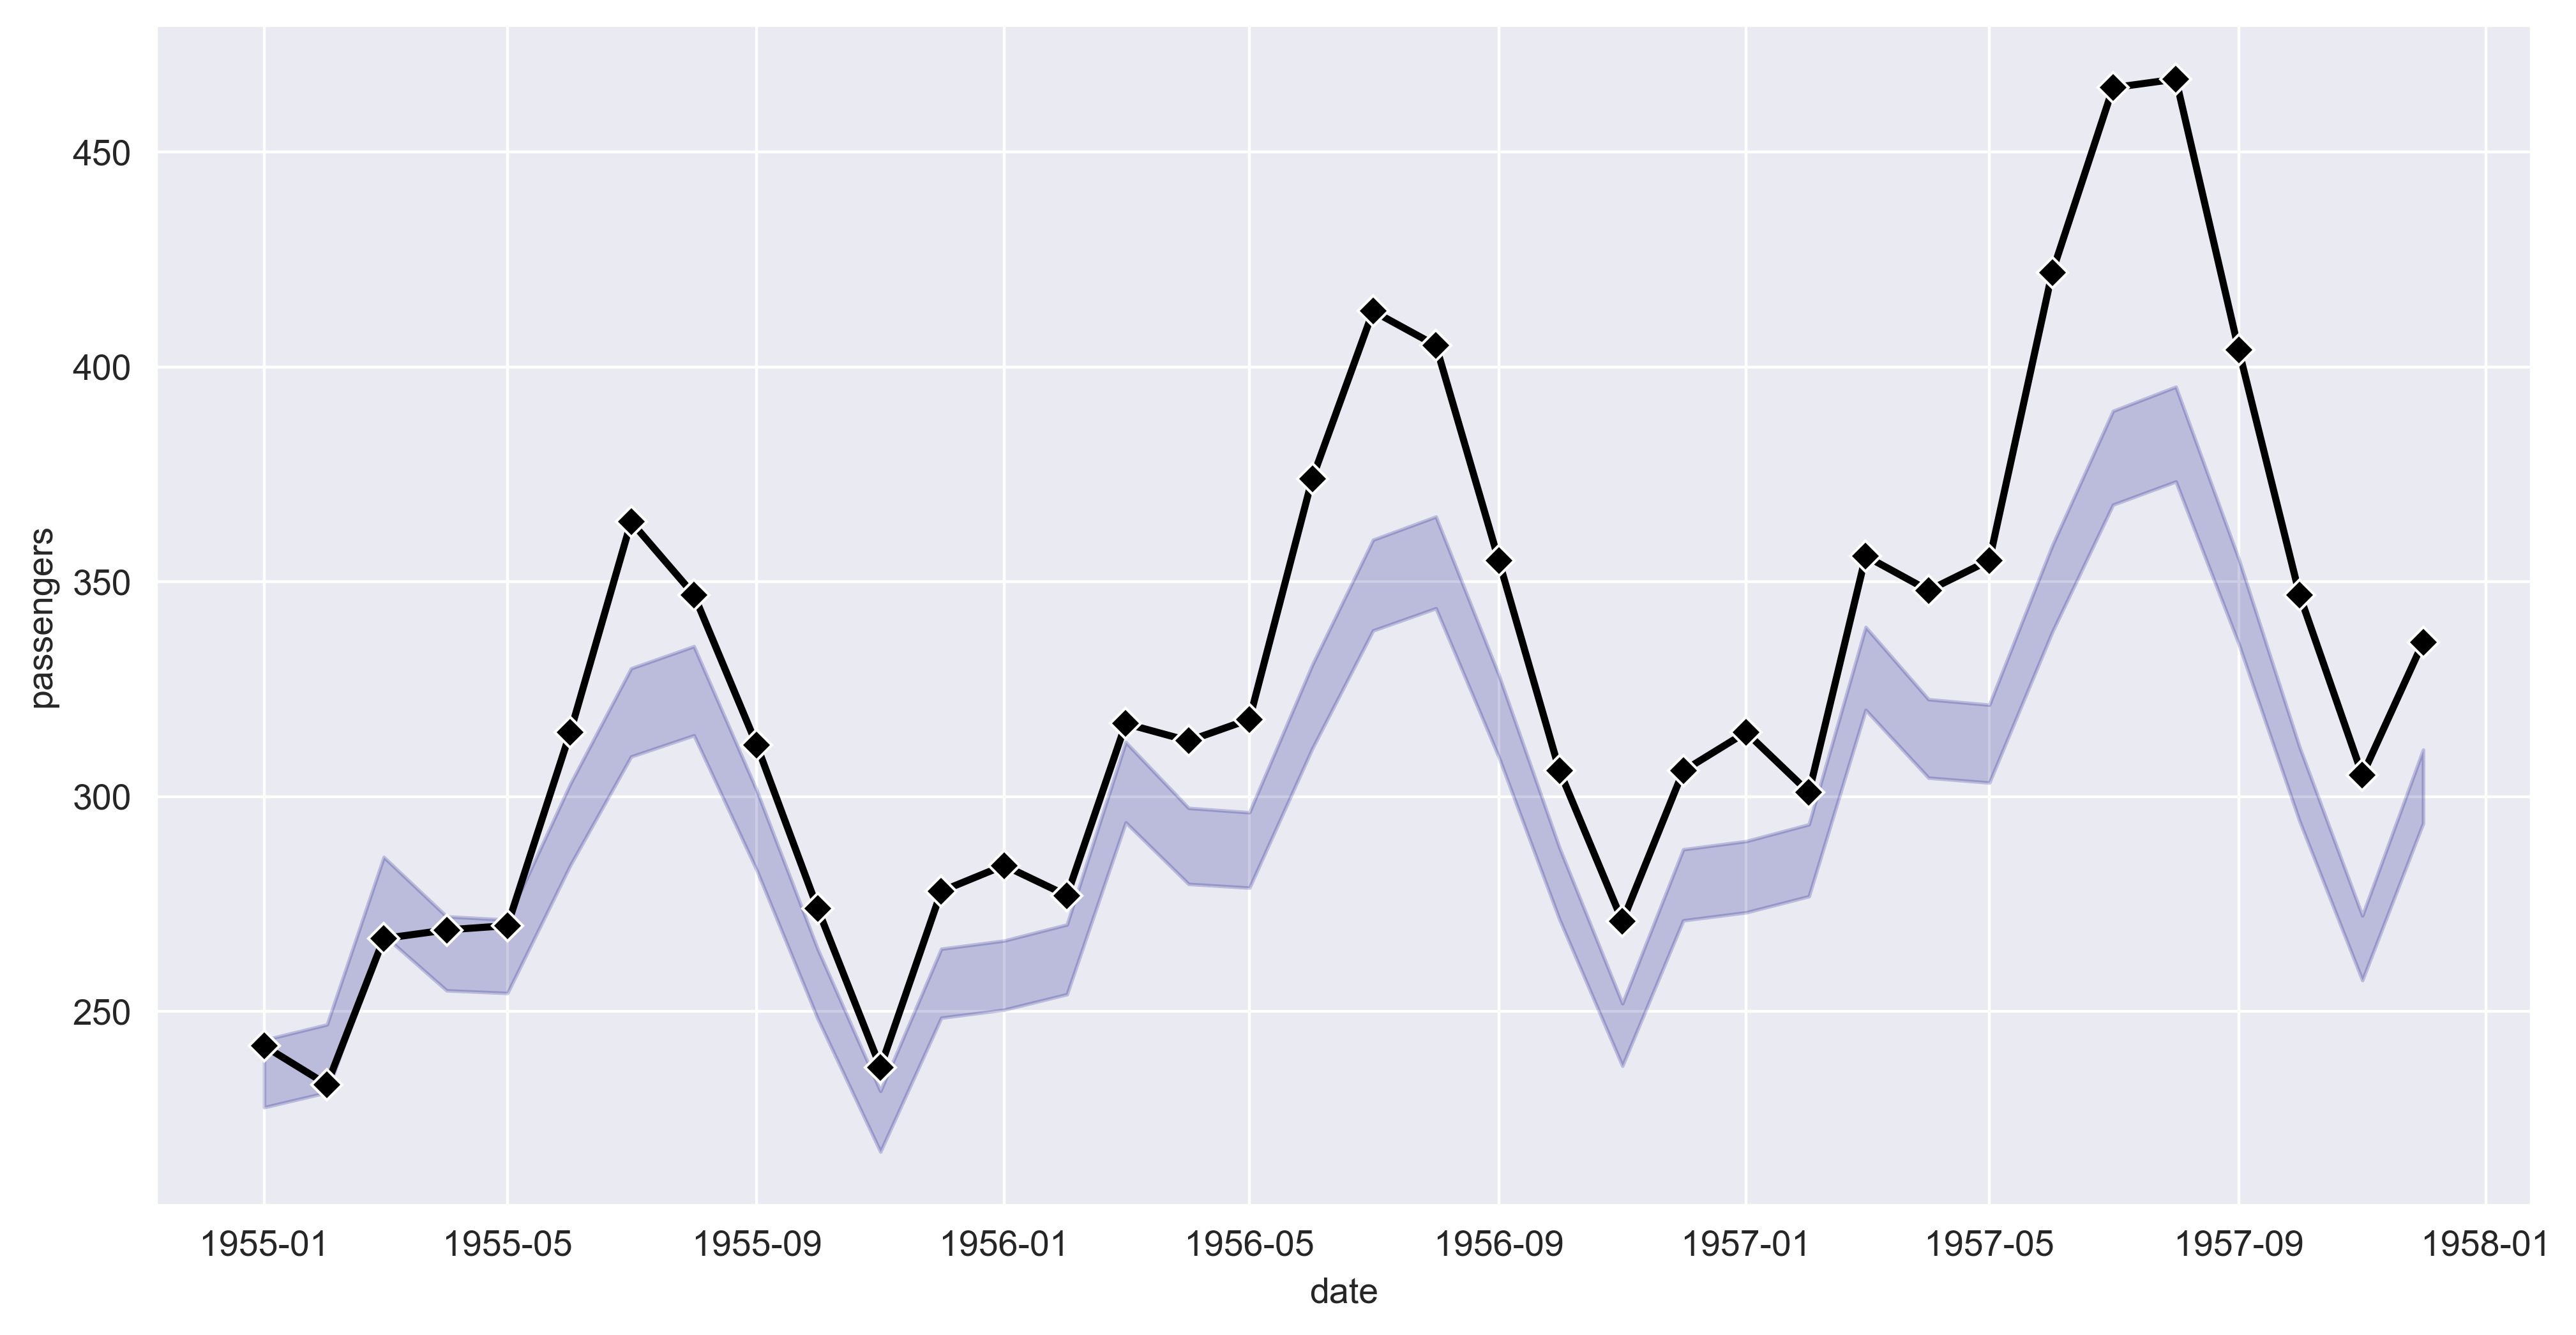

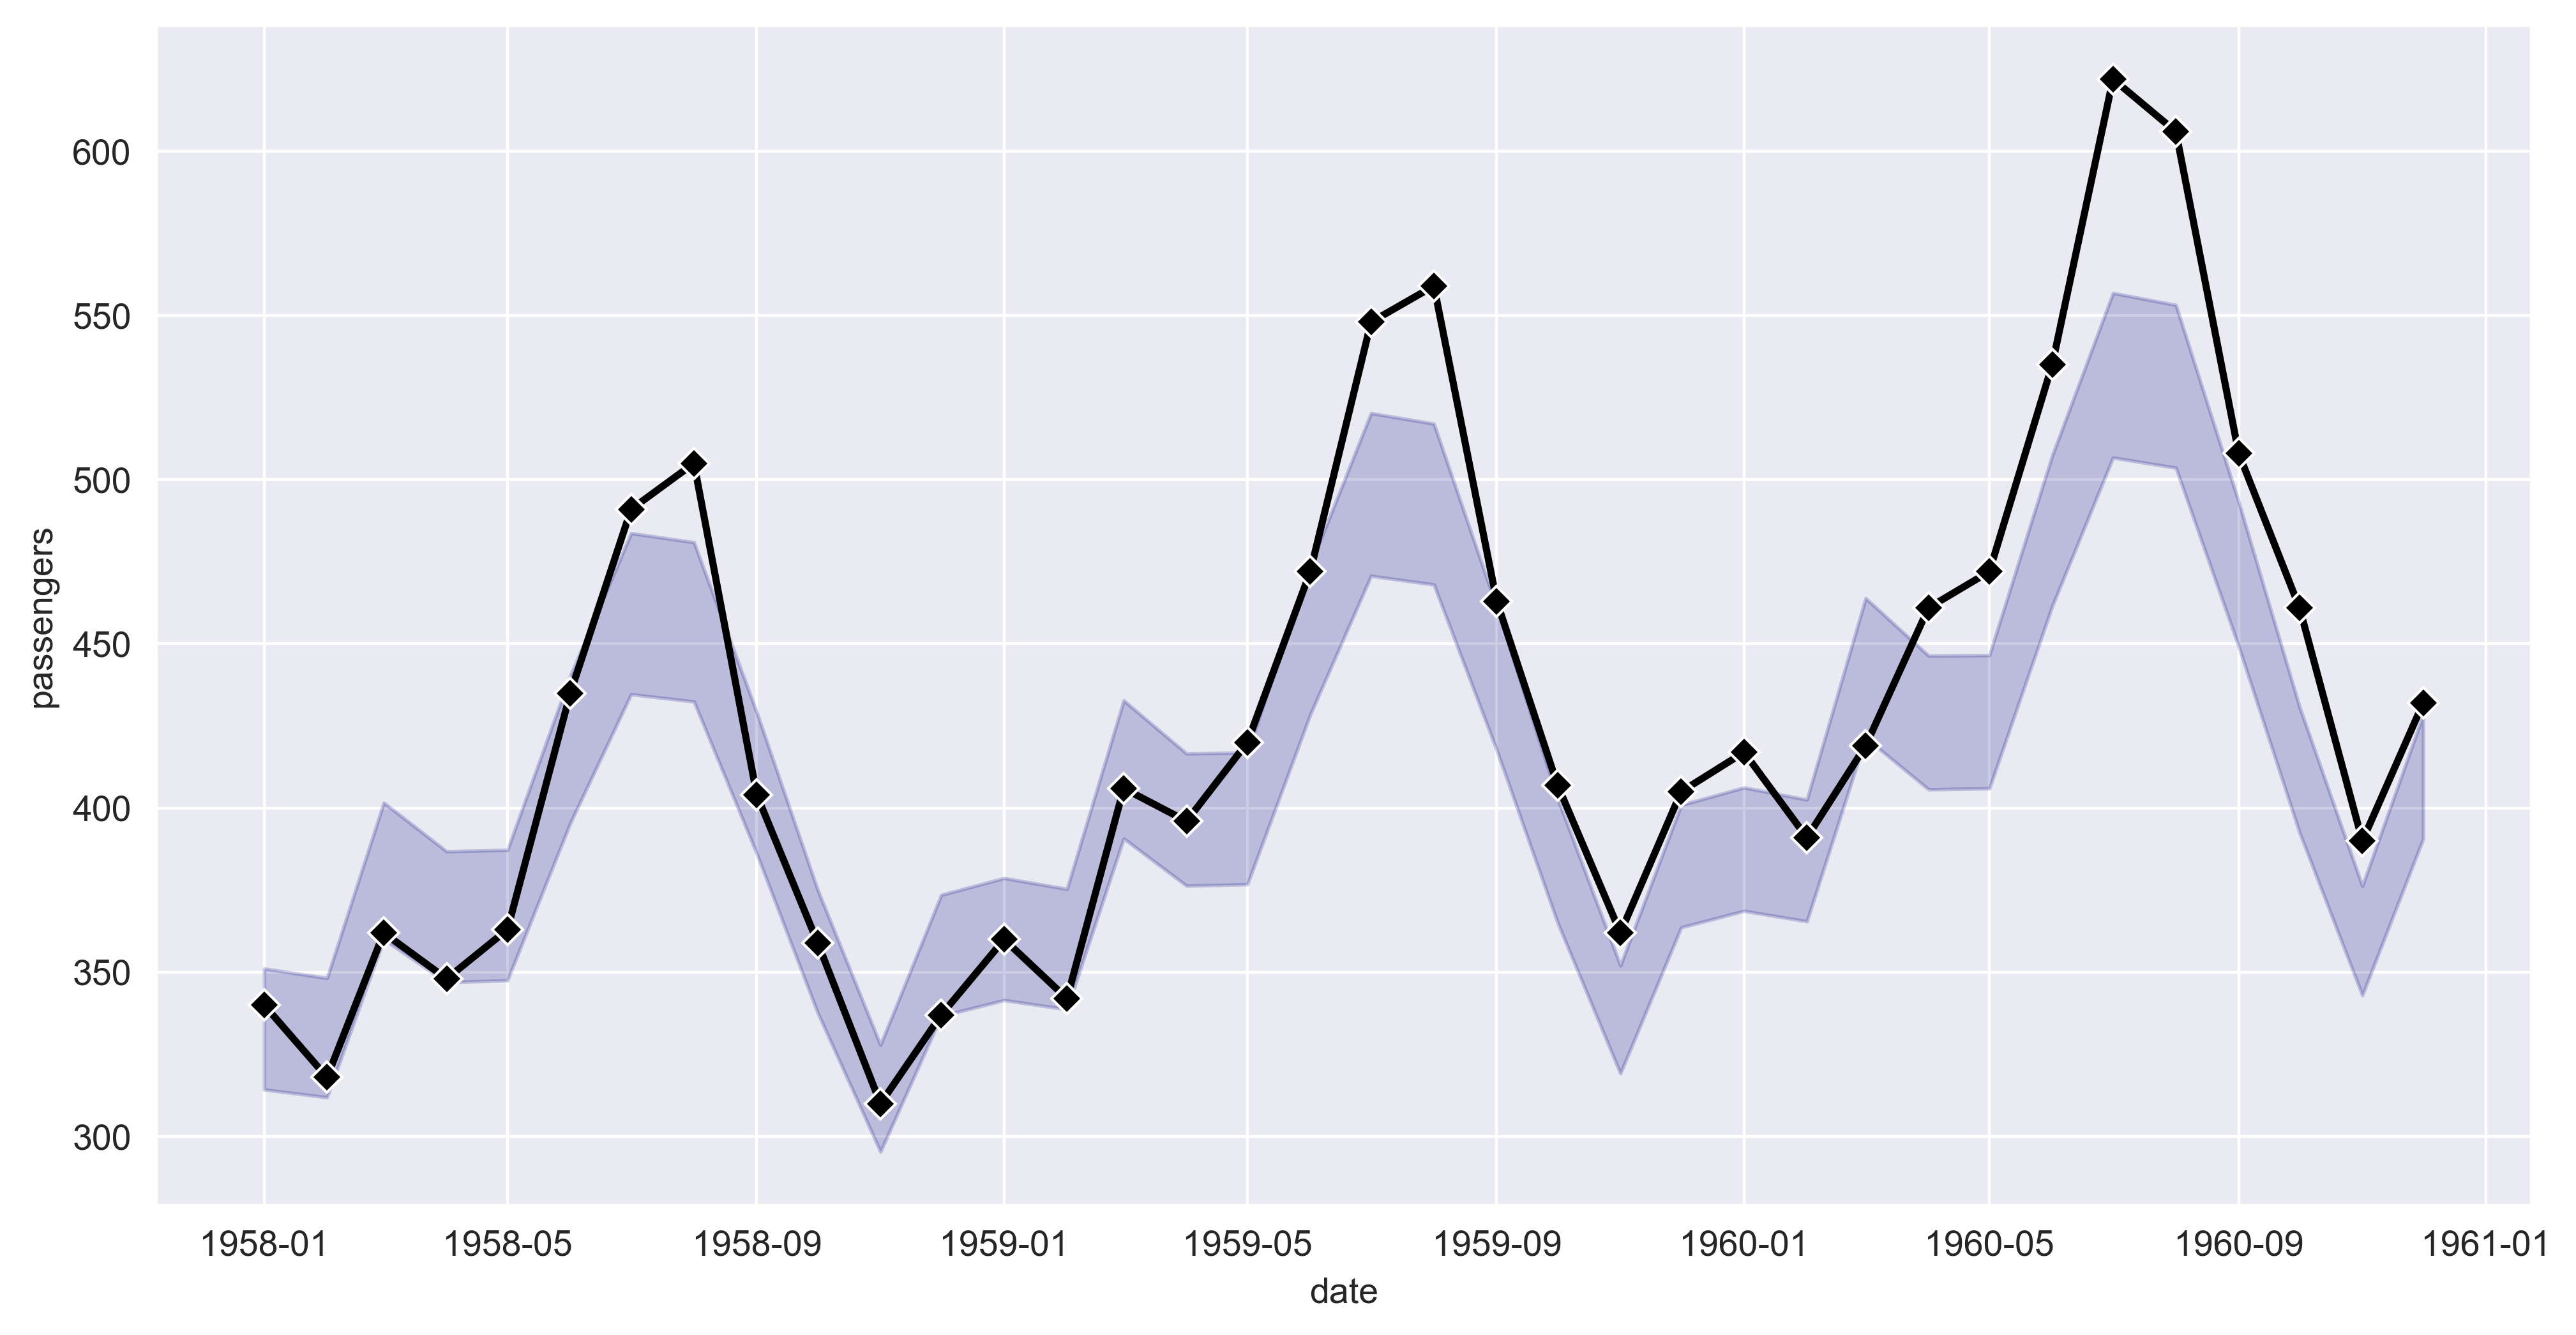

In [18]:
for test in ([test1, test2, test3]):
    plt.figure(figsize=(12,6), dpi=400)
    sns.lineplot(data=test, x='date', y='passengers', color='black', marker='D', linewidth=2)
    plt.fill_between(test['date'], 
                     test['obs_ci_lower'], 
                     test['obs_ci_upper'], color='navy',alpha=0.2)
    plt.plot()

In [19]:
inside = []
for test in [test1, test2, test3]:
    a = np.count_nonzero((test['obs_ci_lower'] < test['passengers']) &
                    (test['obs_ci_upper'] > test['passengers']))
    inside.append(a)
pct_inside = np.array(inside)/36
print('Percentage inside each of three prediction interval:', np.around(pct_inside, 2))
print('Average percentage inside the prediction intervals:', round(np.mean(pct_inside),2
                                                                 )
     )

Percentage inside each of three prediction interval: [0.47 0.11 0.44]
Average percentage inside the prediction intervals: 0.34


#### The above results are really far from ideal. We should be around to 0.95

#
### It's obvious that prediction intervals do very poorly with either model. Can we improve upon it? Let's try getting another and bigger t-value

![1%20_B31fOIzSqyXp1rDPGKPsg.webp](attachment:1%20_B31fOIzSqyXp1rDPGKPsg.webp)

#### We've got to replace the t-value.
#### This will be more clear in a moment
####

In [20]:
# First, create a function to make in-sample predictions.
# We will use it to get residuals
def ols_fit_pred(y,X):
    # Fit ols model 
    model = sm.OLS(y, sm.add_constant(X)).fit()
    # and make predictions
    ols_pred = model.get_prediction(sm.add_constant(X))
    return ols_pred

In [21]:
results = []
y = [trend1['trend'].dropna(), trend2['trend'].dropna(), trend3['trend'].dropna()]
X = [trend1['trend'].dropna().index, trend2['trend'].dropna().index, trend3['trend'].dropna().index]

for i,j in zip(y,X):
    results.append(ols_fit_pred(i,j))

In [22]:
# Remove NaN's and reset index to make the observations compatible with those of results tables
season_1 = seasonal1[trend1.trend.notnull()].reset_index()['seasonal']
season_2 = seasonal2[trend2.trend.notnull()].reset_index()['seasonal']
season_3 = seasonal3[trend3.trend.notnull()].reset_index()['seasonal']

passengers_1 = train1[trend1.trend.notnull()].reset_index()['passengers']
passengers_2 = train2[trend2.trend.notnull()].reset_index()['passengers']
passengers_3 = train3[trend3.trend.notnull()].reset_index()['passengers']

#
#### Now, obtain the errors or residuals for the in-sample prediction of passengers in train1, train2 and train3

In [23]:
# get errors of model when predicting train data
errors_1 = (passengers_1-results[0].summary_frame()['mean']*season_1)
errors_2 = (passengers_2-results[1].summary_frame()['mean']*season_2)
errors_3 = (passengers_3-results[2].summary_frame()['mean']*season_3)

In [24]:
from scipy import stats

print('First split deg.freedom, mean, scale:', stats.t.fit(errors_1))
print('Second split deg.freedom, mean, scale:', stats.t.fit(errors_2))
print('Third split deg.freedom, mean, scale:', stats.t.fit(errors_3))

First split deg.freedom, mean, scale: (5.154775528819744, -0.25730379457264607, 3.752619921934115)
Second split deg.freedom, mean, scale: (4.953492083450377, -0.2596729841213896, 6.006654146789295)
Third split deg.freedom, mean, scale: (16.23520648918504, -0.3417771625416013, 11.181782333796185)


#
####  The results tables give us the mean s.e but not the obs s.e
#### We can calculate it with the following code

In [25]:
# Get the t-scores necessary to calculate P.I's and C.I's in each split
t_score_1 = stats.t.ppf(q=1-0.05/2, df=len(errors_1)-2)
t_score_2 = stats.t.ppf(q=1-0.05/2, df=len(errors_2)-2)
t_score_3 = stats.t.ppf(q=1-0.05/2, df=len(errors_3)-2)

In [26]:
# The results tables give us the mean s.e but not the obs s.e
# We can calculate it with the following code
obs_se_1 = (test1['obs_ci_upper']-test1['predict'])/t_score_1
obs_se_2 = (test2['obs_ci_upper']-test2['predict'])/t_score_2
obs_se_3 = (test3['obs_ci_upper']-test3['predict'])/t_score_3

#
#### By trial and error, we arrived at the values below for the scale parameters. 
#### • Scale_1 is taken from the scale parameter when we fitted a student-t distribution to errors_1
#### • Scale_2 is the parameter necessary to fit around 95% of the test1 passengers observations inside the P.I. But we do not apply scale_2 to test1 but to test2, since we want to avoid data leakage.
#### • Scale_3 is the parameter necessary to fit around 95% of the sum of test1 and test2 passengers observation inside the P.I. But we do not apply scale_3 to test1 and test2 but to test3, since we want to avoid data leakage.
#### • Scale_3 is the parameter necessary to fit around 95% of the sum of the test1, test2, and test3 passengers observations inside the P.I. But we do not apply scale_3 to test1, test2 and test3 but to the final prediction, since we want to avoid data leakage

In [27]:
# scale: 2.53, 4.65, 4,2
scale_1 = stats.t.fit(errors_1)[2]
scale_2 = 2.53
scale_3 = 4.65
scale_4 = 4.2

new_t_score_1 = stats.t.ppf(q=1-0.05/2, df=stats.t.fit(errors_1)[0])
upp_t_score_1 = new_t_score_1 * scale_1 
low_t_score_1 = -new_t_score_1 * scale_1 

new_t_score_2 = stats.t.ppf(q=1-0.05/2, df=stats.t.fit(errors_2)[0])
upp_t_score_2 = new_t_score_2 * scale_2
low_t_score_2 = -new_t_score_2 * scale_2

new_t_score_3 = stats.t.ppf(q=1-0.05/2, df=stats.t.fit(errors_3)[0])
upp_t_score_3 = new_t_score_3 * scale_3
low_t_score_3 = -new_t_score_3 * scale_3

In [28]:
new_obs_ci_upper_1 = test1['predict']+upp_t_score_1*obs_se_1
new_obs_ci_lower_1 = test1['predict']+low_t_score_1*obs_se_1

new_obs_ci_upper_2 = test2['predict']+upp_t_score_2*obs_se_2
new_obs_ci_lower_2 = test2['predict']+low_t_score_2*obs_se_2

new_obs_ci_upper_3 = test3['predict']+upp_t_score_3*obs_se_3
new_obs_ci_lower_3 = test3['predict']+low_t_score_3*obs_se_3

In [29]:
for test, upp, low, split in zip([test1, test2, test3], 
                          [new_obs_ci_upper_1, new_obs_ci_upper_2, new_obs_ci_upper_3],
                          [new_obs_ci_lower_1, new_obs_ci_lower_2, new_obs_ci_lower_3],
                          ['Test 1:', 'Test 2:', 'Test 3:']):
    
    inside=np.count_nonzero((test.passengers < upp) &
                     (test.passengers > low))
    print(split, 'number of observations inside its corresponding P.I: ',inside)

Test 1: number of observations inside its corresponding P.I:  36
Test 2: number of observations inside its corresponding P.I:  19
Test 3: number of observations inside its corresponding P.I:  36


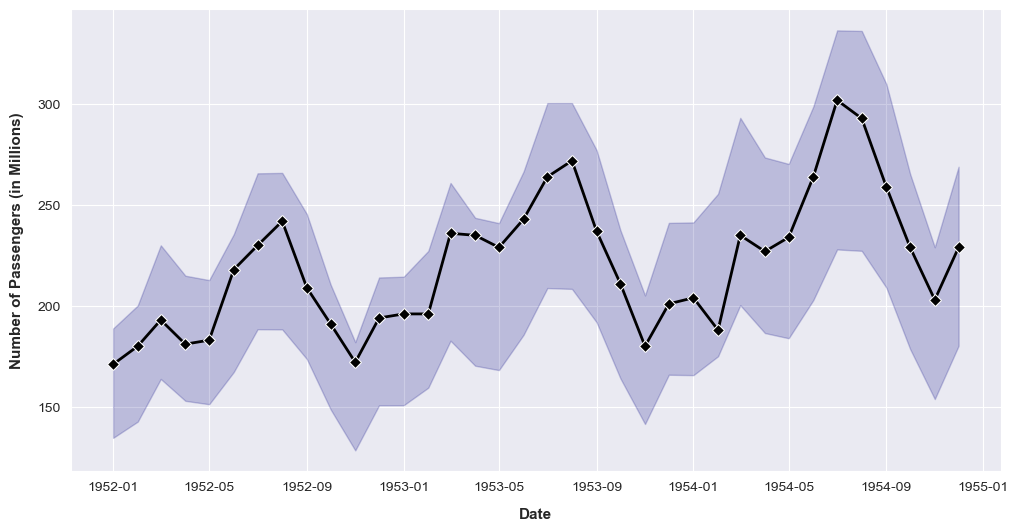

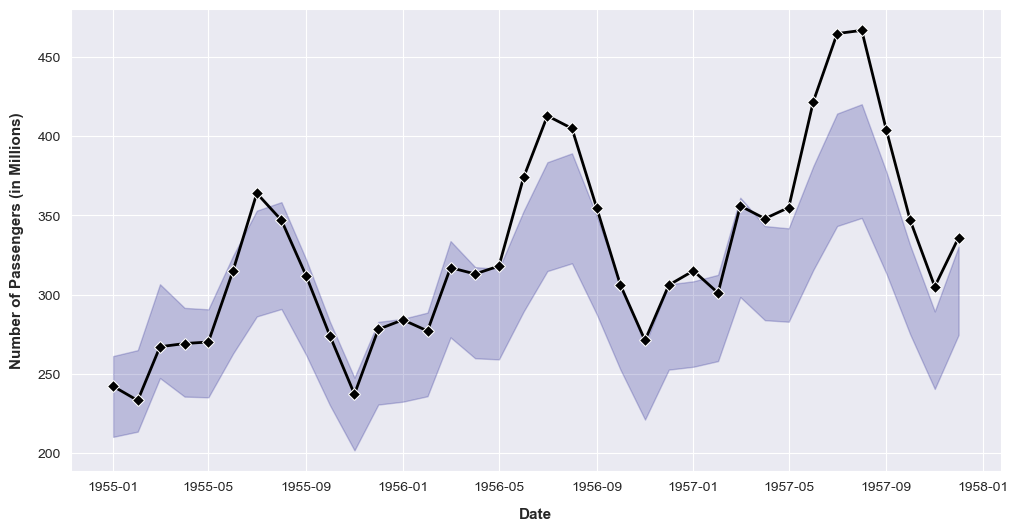

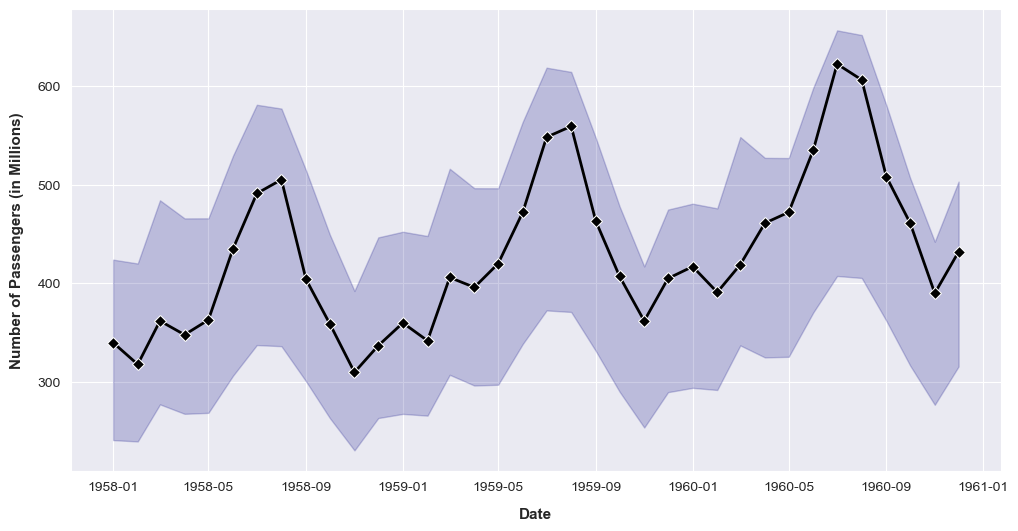

In [30]:
for test, upper, lower in zip([test1, test2, test3],
                              [new_obs_ci_upper_1, new_obs_ci_upper_2, new_obs_ci_upper_3],
                              [new_obs_ci_lower_1, new_obs_ci_lower_2, new_obs_ci_lower_3],
                              ):
    plt.figure(figsize=(12,6))
    sns.lineplot(data=test, x='date', y='passengers', color='black', marker='D', linewidth=2)
    plt.ylabel('Number of Passengers (in Millions)' ,weight='bold', size=11,labelpad=10)
    plt.xlabel('Date', weight='bold', size=11,labelpad=10)
    plt.fill_between(test['date'], upper, lower, color='navy',alpha=0.2)
    plt.plot()

#
## Just to finish, let's see the forecast for the next 36 months not included in the original data

#
#### Create future dates

In [31]:
from datetime import datetime
import pandas as pd

# start date
start_date = datetime.strptime("1961-01-01", "%Y-%m-%d")
end_date = datetime.strptime("1964-1-01", "%Y-%m-%d")

date_list = pd.date_range(start_date, end_date, freq='M')
print(f"Creating list of dates starting from {start_date} to {end_date}")
print(date_list)

Creating list of dates starting from 1961-01-01 00:00:00 to 1964-01-01 00:00:00
DatetimeIndex(['1961-01-31', '1961-02-28', '1961-03-31', '1961-04-30',
               '1961-05-31', '1961-06-30', '1961-07-31', '1961-08-31',
               '1961-09-30', '1961-10-31', '1961-11-30', '1961-12-31',
               '1962-01-31', '1962-02-28', '1962-03-31', '1962-04-30',
               '1962-05-31', '1962-06-30', '1962-07-31', '1962-08-31',
               '1962-09-30', '1962-10-31', '1962-11-30', '1962-12-31',
               '1963-01-31', '1963-02-28', '1963-03-31', '1963-04-30',
               '1963-05-31', '1963-06-30', '1963-07-31', '1963-08-31',
               '1963-09-30', '1963-10-31', '1963-11-30', '1963-12-31'],
              dtype='datetime64[ns]', freq='M')


#
#### Create dataframe containing future dates and eventual predictions

In [32]:
forecast = pd.DataFrame()
forecast['date'] = date_list

In [33]:
decompose_result = seasonal_decompose(df.set_index('date')['passengers'], 
                                      model="multiplicative", period=12)

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

In [34]:
# Make in-sample predictions
# Define variables
y = trend.dropna()
X = trend.dropna().reset_index().index

ols_pred = ols_fit_pred(y,X).summary_frame()

ols_pred.head()

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  103.316838  1.897588      99.562687     107.070990     81.305719   
1  105.983776  1.875985     102.272364     109.695188     83.979906   
2  108.650714  1.854468     104.981871     112.319558     86.653984   
3  111.317652  1.833041     107.691199     114.944104     89.327953   
4  113.984590  1.811706     110.400345     117.568834     92.001812   

   obs_ci_upper  
0    125.327958  
1    127.987646  
2    130.647444  
3    133.307351  
4    135.967367

In [35]:
# Remove the rows of passengers where trend is NaN
# Reset index
passengers = df['passengers'][trend.reset_index().dropna().index]
passengers = passengers.reset_index()['passengers']
passengers

0      148
1      148
2      136
3      119
4      104
      ... 
127    391
128    419
129    461
130    472
131    535
Name: passengers, Length: 132, dtype: int64

In [36]:
# Remove the rows of seasonal where trend is NaN
# Reset index
season = seasonal[trend.dropna().index]
season = season.reset_index()['seasonal']
season

0      1.226556
1      1.219911
2      1.060492
3      0.921757
4      0.801178
         ...   
127    0.883625
128    1.007366
129    0.975906
130    0.981378
131    1.112776
Name: seasonal, Length: 132, dtype: float64

In [37]:
# Fit a t-stat to the errors
errors = passengers - ols_pred['mean']*season
t_score = stats.t.ppf(q=1-0.05/2, df=len(errors)-2)

# Calculate new t-value
new_t_score = stats.t.ppf(q=1-0.05/2, df=stats.t.fit(errors)[0])
upp_t_score = new_t_score * scale_4
low_t_score = -new_t_score * scale_4

#
#### Now, it's time to make out of sample point predictions 

In [38]:
# Define variables
y = trend.dropna()
X = trend.dropna().reset_index().index
#X = np.column_stack((X, X**2))

model = sm.OLS(y, sm.add_constant(X)).fit()
# and make prediction
Xnew = np.linspace(132, 132+36, 36, endpoint=False)
#Xnew = np.column_stack((Xnew, Xnew**2))

ols_pred = model.get_prediction(sm.add_constant(Xnew))
ols_pred.summary_frame().head()

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  455.352625  1.919275     451.555569     459.149680    433.334147   
1  458.019562  1.941043     454.179442     461.859683    435.993618   
2  460.686500  1.962888     456.803161     464.569840    438.652979   
3  463.353438  1.984809     459.426730     467.280146    441.312232   
4  466.020376  2.006804     462.050155     469.990596    443.971376   

   obs_ci_upper  
0    477.371102  
1    480.045507  
2    482.720021  
3    485.394644  
4    488.069375

In [39]:
# We have mean_se but we need obs_se.
obs_se = (ols_pred.summary_frame()['obs_ci_upper']-ols_pred.summary_frame()['mean'])/t_score

#
#### Now, we make upper and lower prediction intervals and plot results

In [40]:
prediction = ols_pred.summary_frame()['mean']*season[:36]
forecast['prediction'] = prediction

upper = prediction + (upp_t_score * obs_se)
lower = prediction + (low_t_score * obs_se)

[]

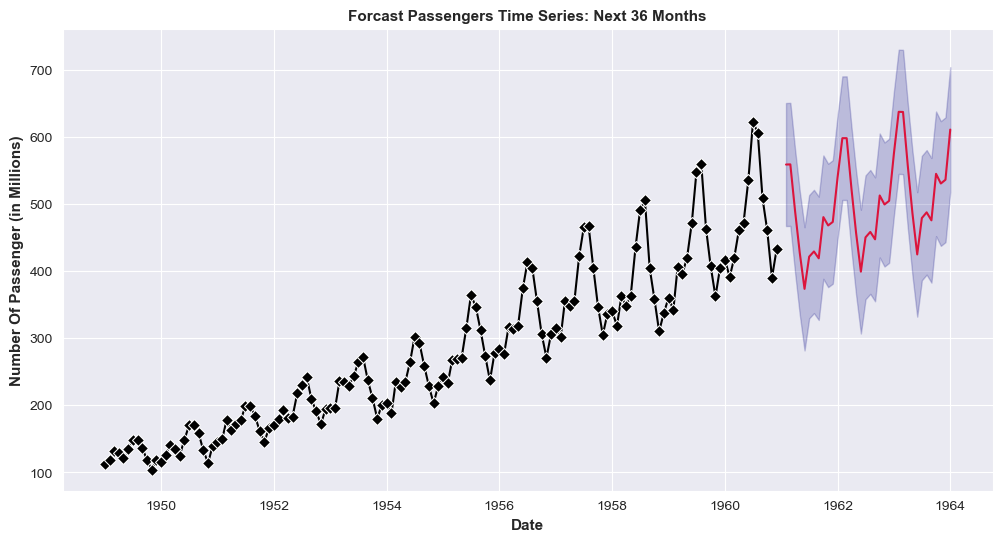

In [41]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='date', y='passengers', color='black', marker='D')
sns.lineplot(data=forecast, x='date', y='prediction', color='crimson')
plt.fill_between(forecast['date'], upper, lower, color='navy',alpha=0.2)
plt.title('Forcast Passengers Time Series: Next 36 Months', weight='bold', size='11')
plt.ylabel('Number Of Passenger (in Millions)', weight='bold', size='11')
plt.xlabel('Date', weight='bold', size='11')

plt.plot()

## Thanks for your attention!